In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import ExcelWriter
from pandas import ExcelFile
from bisect import bisect
import operator
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
def read_data(file_name):
    file_path = '../FallCatcher_Data/' + file_name
    data = pd.read_csv(file_path,sep=',',names = ['time_counter','accel_base_X','accel_base_Y','accel_base_Z','gyro_base_X',
                                                  'gyro_base_Y','gyro_base_Z','accel_right_X','accel_right_Y','accel_right_Z',
                                                  'gyro_right_X','gyro_right_Y','gyro_right_Z','accel_left_X','accel_left_Y',
                                                  'accel_left_Z','gyro_left_X','gyro_left_Y','gyro_left_Z','fall_detection',
                                                  'fall_check','impact_value'])
    return data

In [4]:
def read_combined_data(file_name,airbag_data):
    file_path = '../FallCatcher_Data/Combined/'+file_name
    data = pd.read_excel(file_path, sheet_name=0)
    data.to_csv(file_name + '.csv', encoding='utf-8')
    data['Time Point Name'] = pd.to_numeric(data['Time Point Name'], errors='coerce')
    data = data[(data['Time Point Name']>100) & (data['Time Point Name'] < 200) &
                (data['Impact milisec'].notnull()) & ((data['Start milisec']) < (airbag_data.iloc[-1][0]))]
    data = data[['Time Point Name','Start milisec','Impact milisec', 'End Milisec','Duration']]
    return data

In [5]:
def add_new_fall_value(airbag_data,manual_data):
    airbag_data['accel_base_mag'] =  np.sqrt(airbag_data['accel_base_X']**2 + airbag_data['accel_base_Y']**2 + 
                                             airbag_data['accel_base_Z']**2)
    for index, row in manual_data.iterrows():
        #add fall_check value from start millisec to end millisec of the window
        airbag_data.loc[(airbag_data['time_counter'] >= row['Start milisec']) &
                        (airbag_data['time_counter'] < row['End Milisec']),'fall_check'] = 88
        
        #add calculated fall value to the window
        airbag_data.loc[(airbag_data['accel_base_mag'] == \
                                                  (airbag_data.loc[(airbag_data['time_counter'] >= row['Start milisec']) & \
                                                                   (airbag_data['time_counter'] < row['End Milisec']),
                                                                   'accel_base_mag'].max())) & \
                                                 (airbag_data['time_counter'] >= row['Start milisec']) & \
                                                 (airbag_data['time_counter'] < row['End Milisec']),
                                                 'cal_impact_milisec'] = 80
        
        # add given Impact millisec of the window
        if(any(airbag_data['time_counter'] == row['Impact milisec'])):
            airbag_data.loc[(airbag_data['time_counter'] == row['Impact milisec']),'impact_value'] =  84
        else:
            airbag_data.loc[bisect(airbag_data['time_counter'].values, row['Impact milisec']),'impact_value'] =  84


In [6]:
def big_size_plot_of_acceleration_vs_time(data,label,x=15,y=10,left = -1,right = -1):
    fig, axs = plt.subplots(figsize=(x,y))
    fig.suptitle('Bace acceleration for AIRBAG-'+label)
    
    axs.plot( data.time_counter*(10**(-3)),data.accel_base_X*(10**(-3)), marker='', color='red', linewidth=1)
    axs.plot( data.time_counter*(10**(-3)),data.accel_base_Y*(10**(-3)), marker='', color='blue', linewidth=1)
    axs.plot( data.time_counter*(10**(-3)),data.accel_base_Z*(10**(-3)), marker='', color='green', linewidth=1)
    axs.scatter(data.time_counter*(10**(-3)),data.fall_detection/4,s=5,c = 'brown')
    axs.scatter(data.time_counter*(10**(-3)),data.fall_check/4,s=5,c = 'yellow')
    axs.scatter(data.time_counter*(10**(-3)),data.cal_impact_milisec/4,s=20,c = 'violet')
    
    if (left>-1 and right>-1):
        axs.set_xlim(left,right)
    elif (left > -1):
        axs.set_xlim(left)
    elif (right > -1):
        axs.set_xlim(right)
    else:
        axs.set_xlim()
    
    axs.set_title('acceleration all axis')

In [7]:
def plot_all_impact_graphs(airbag_data,manual_data):
    for index, row in manual_data.iterrows():
        big_size_plot_of_acceleration_vs_time(data=airbag_data,label='S2',left=row['Start milisec']*(10**(-3))/60,
                                              right= row['End Milisec']*(10**(-3))/60)

In [8]:
def plot_offset(airbag_data,manual_data):

    plt.figure(figsize=(20,10))

    cal_impact_value =[]
    impact_value = []
    difference_impact =[]

    for index, row in manual_data.iterrows():
        cal_impact_value.append( airbag_data.loc[(airbag_data['accel_base_mag'] == \
                                                  (airbag_data.loc[(airbag_data['time_counter'] >= row['Start milisec']) & \
                                                                   (airbag_data['time_counter'] < row['End Milisec']),
                                                                   'accel_base_mag'].max())) & \
                                                 (airbag_data['time_counter'] >= row['Start milisec']) & \
                                                 (airbag_data['time_counter'] < row['End Milisec']),
                                                 'time_counter'].values[0]*10**(-3)/60)
        impact_value.append(row['Impact milisec']*10**(-3)/60)

        difference_impact =list(map(operator.sub, cal_impact_value, impact_value))
        impact_df = pd.DataFrame(np.column_stack([cal_impact_value,impact_value,difference_impact]),
                                 columns=['cal_impact_value', 'impact_value',' difference_in_min'])
        print(impact_df)

        barWidth = 0.3
        r1 = np.arange(len(cal_impact_value))
        r2 = [x + barWidth for x in r1]
        r3 = [x + barWidth for x in r2]

        plt.bar(r1, cal_impact_value, color='#7f6d5f', width=barWidth, edgecolor='white', label='cal_impact_value')
        plt.bar(r2, impact_value, color='#557f2d', width=barWidth, edgecolor='white', label='impact_value') 
        plt.show()

# For - S1

In [9]:
s1_data=read_data('Airbag-S1.CSV')
s1_combined = read_combined_data('S1-combined.xlsx',s1_data)
add_new_fall_value(s1_data,s1_combined)

    cal_impact_value  impact_value   difference_in_min
0          11.383783     11.394000           -0.010217
1          12.066050     12.076550           -0.010500
2          12.899583     12.912767           -0.013183
3          13.571150     13.581400           -0.010250
4          14.102883     14.109583           -0.006700
5          15.279283     15.288650           -0.009367
6          15.707017     15.724283           -0.017267
7          16.132250     16.136550           -0.004300
8          16.819717     16.826383           -0.006667
9          17.226850     17.236483           -0.009633
10         19.651733     19.659450           -0.007717
11         20.377583     20.384683           -0.007100
12         20.783117     20.789917           -0.006800
13         21.839250     21.848017           -0.008767
14         22.404483     22.410617           -0.006133
15         22.832250     22.837567           -0.005317
16         23.323183     23.330500           -0.007317
17        

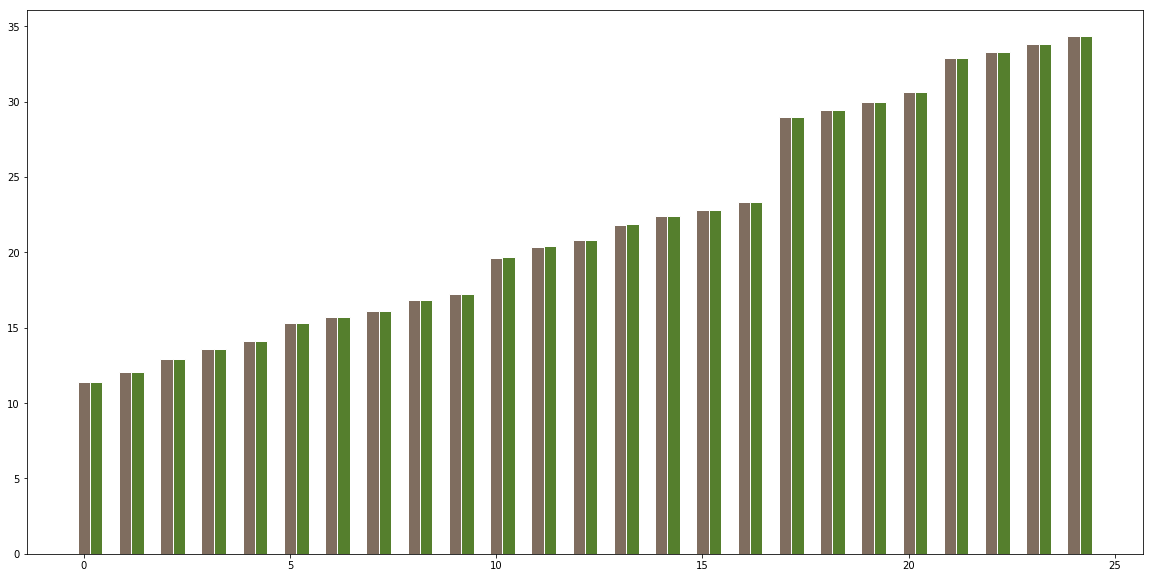

In [54]:
plot_offset(airbag_data=s1_data,manual_data=s1_combined)

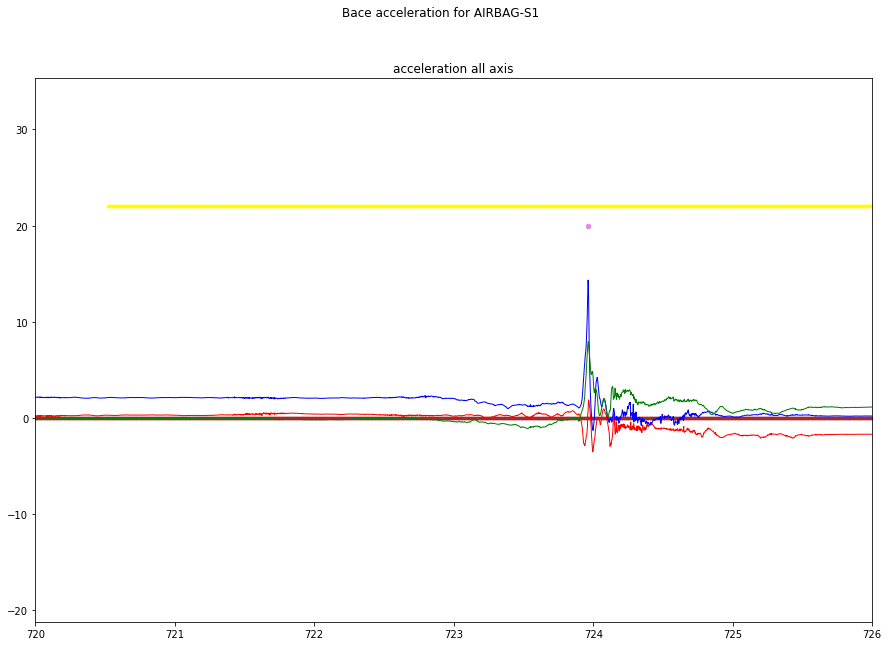

In [11]:
big_size_plot_of_acceleration_vs_time(data=s1_data,label='S1',left=720,right=726)

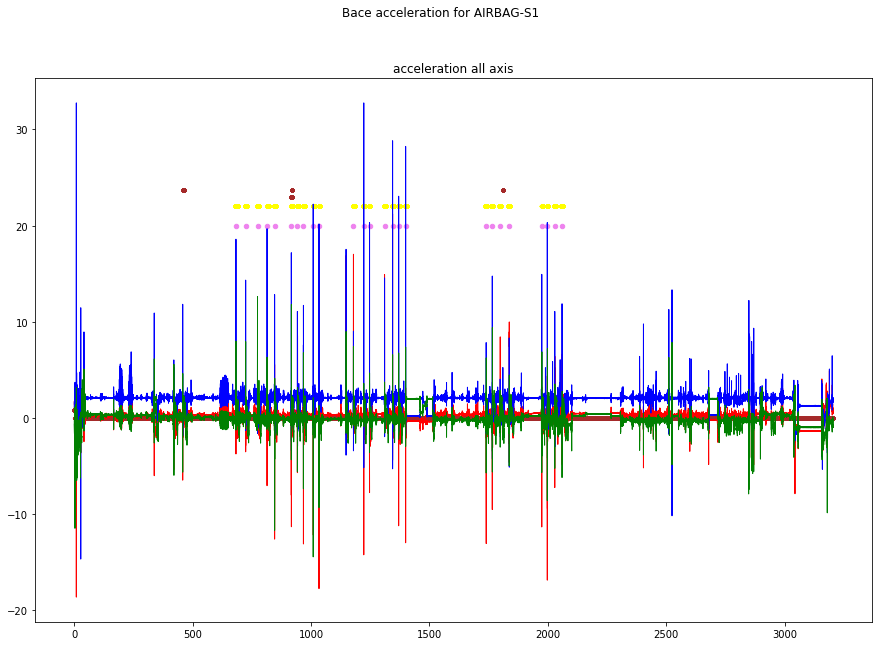

In [10]:
big_size_plot_of_acceleration_vs_time(data=s1_data,label='S1')

# For S2

In [14]:
s2_data=read_data('Airbag-S2.CSV')
s2_combined = read_combined_data('S2-combined.xlsx',s2_data)

In [15]:
add_new_fall_value(s2_data,s2_combined)

    cal_impact_value  impact_value   difference_in_min
0           6.592783      6.652833           -0.060050
1           7.355083      7.411900           -0.056817
2           8.450050      8.505933           -0.055883
3           8.961717      9.019183           -0.057467
4          12.660350     12.717267           -0.056917
5          13.356217     13.406817           -0.050600
6          14.070517     14.129283           -0.058767
7          14.627650     14.683067           -0.055417
8          15.378017     15.435017           -0.057000
9          15.746450     15.801433           -0.054983
10         19.078450     19.134450           -0.056000
11         19.497950     19.552800           -0.054850
12         19.988283     20.044383           -0.056100
13         20.433983     20.490433           -0.056450
14         20.844850     20.900217           -0.055367
15         21.139150     21.180500           -0.041350
16         25.257017     25.312117           -0.055100
17        

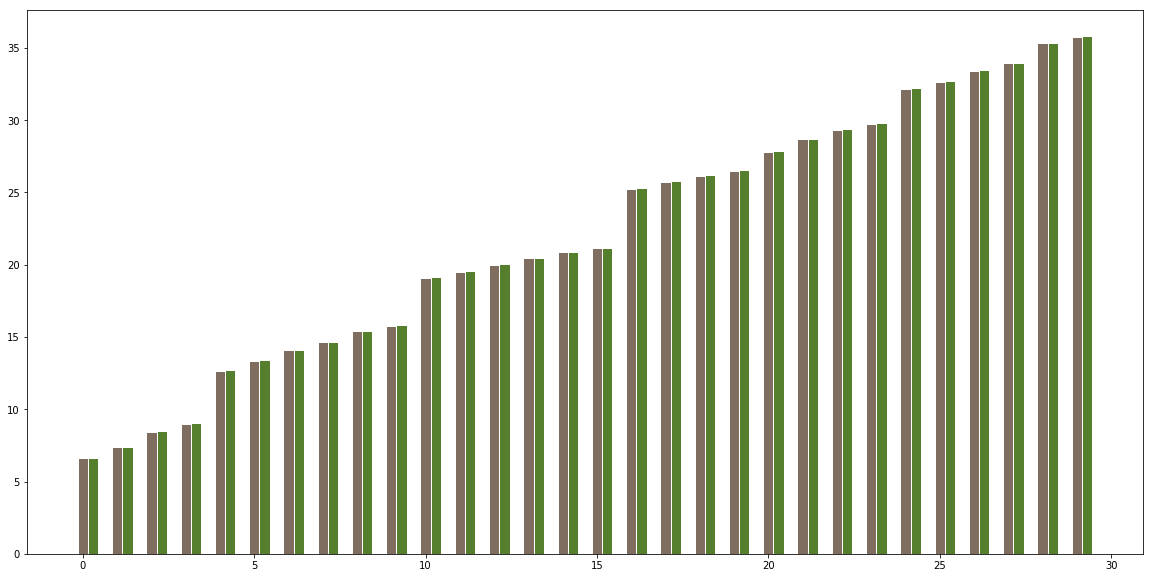

In [55]:
plot_offset(s2_data,s2_combined)

In [ ]:
big_size_plot_of_acceleration_vs_time(data=s2_data,label='S2')

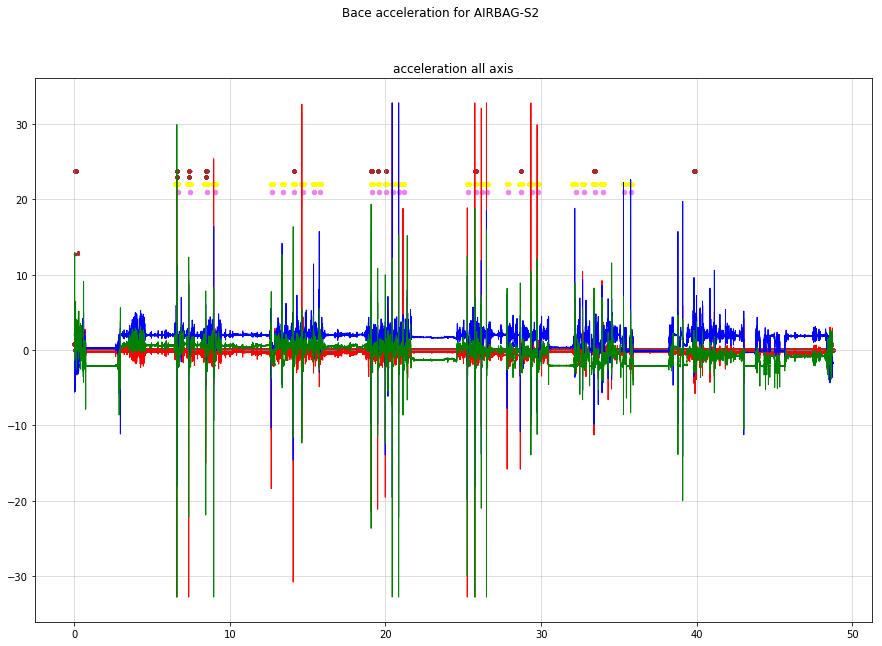

In [179]:
big_size_plot_of_acceleration_vs_time(data=s2_data,label='S2')

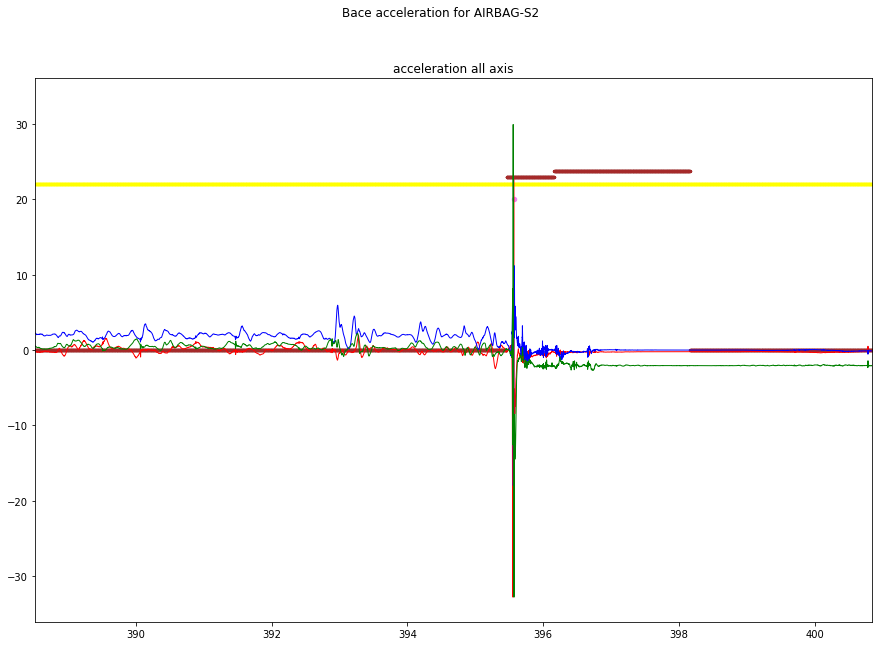

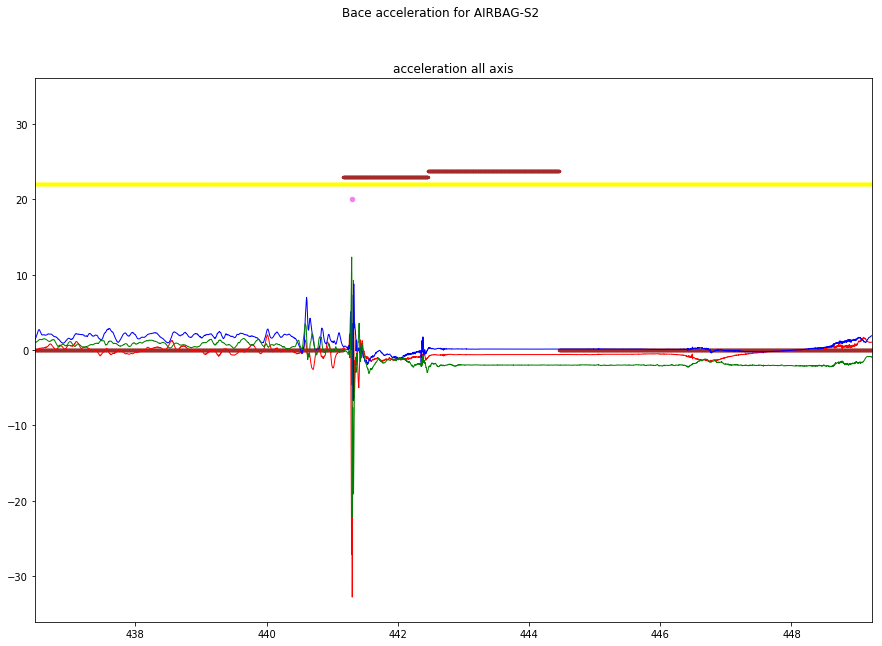

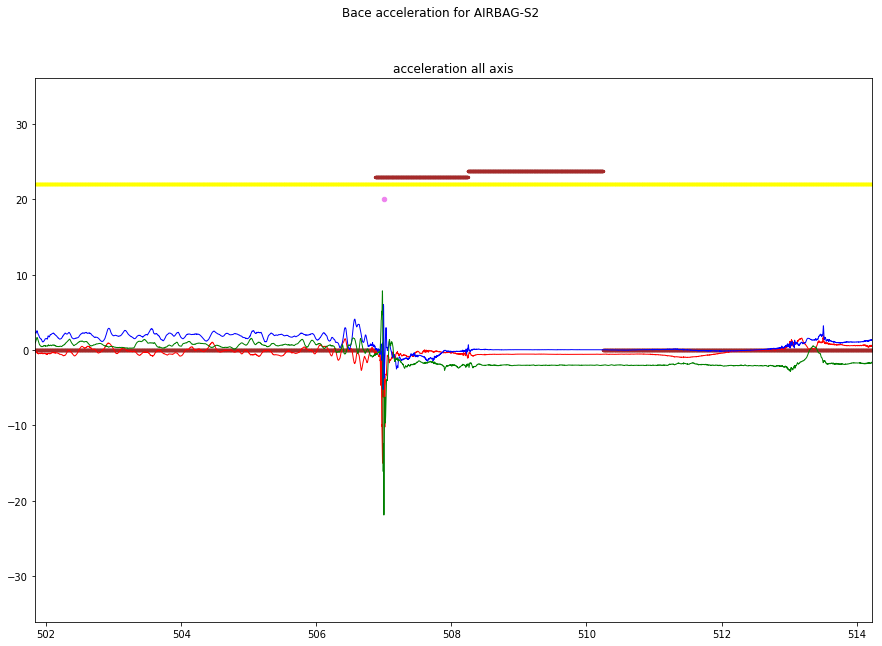

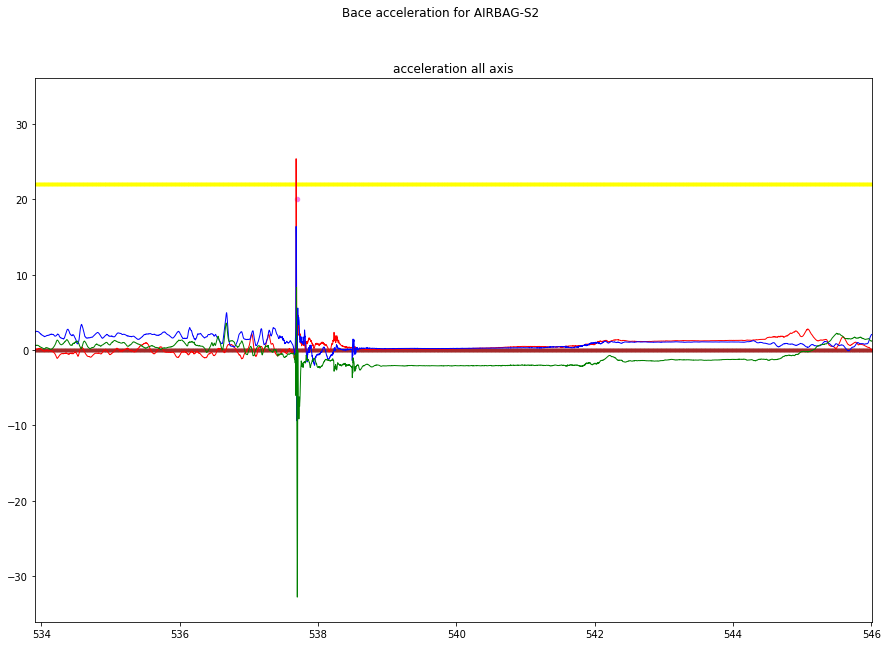

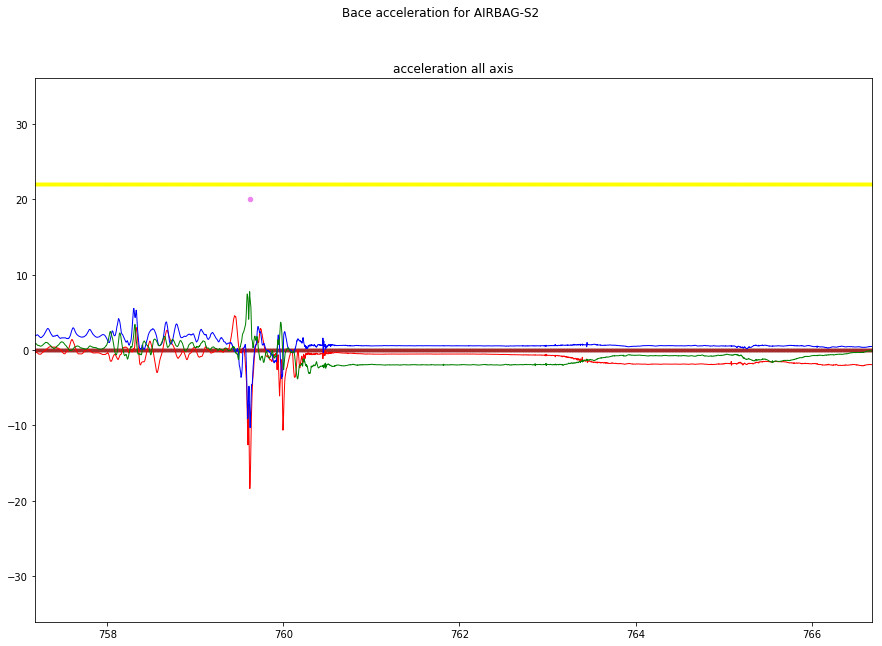

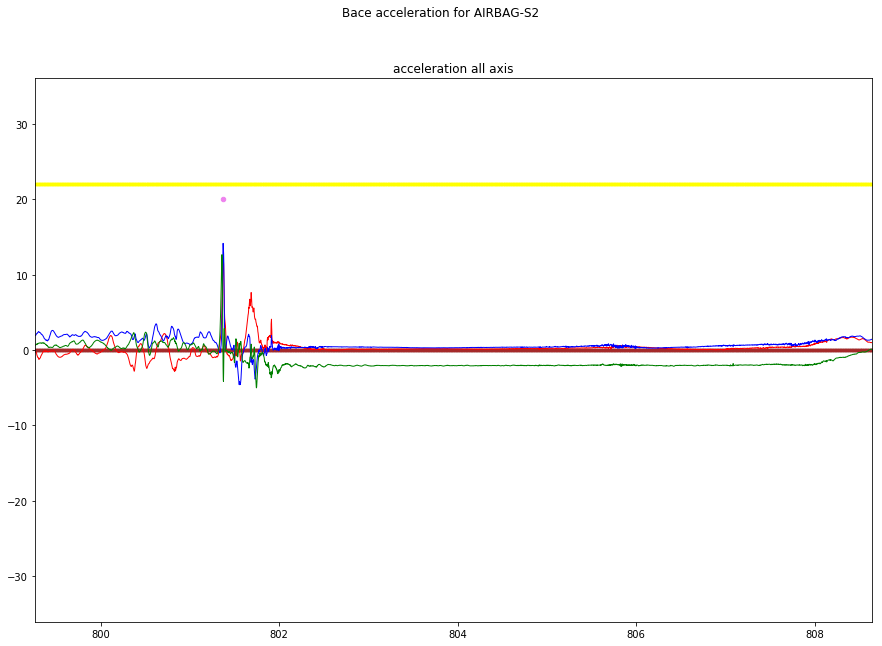

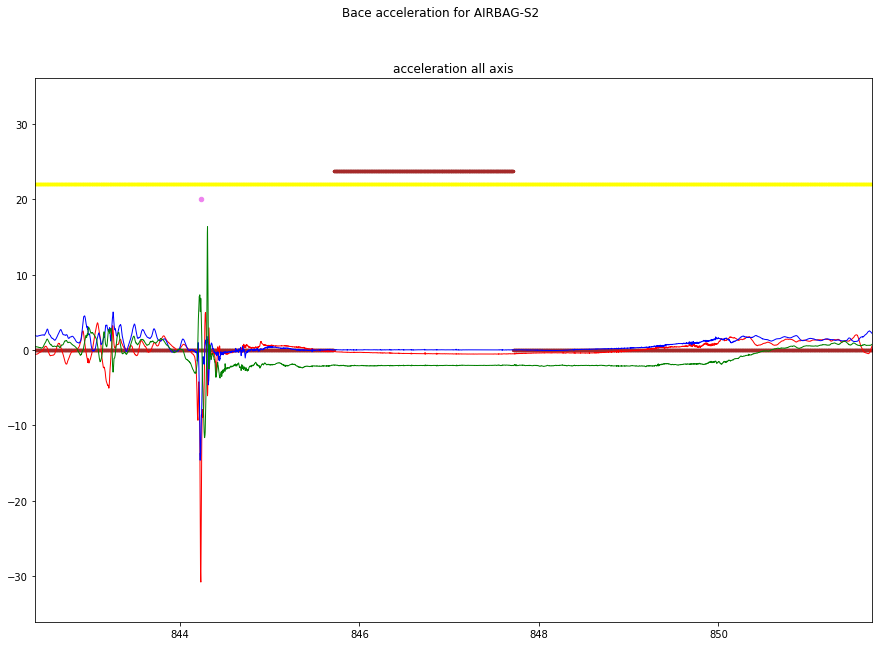

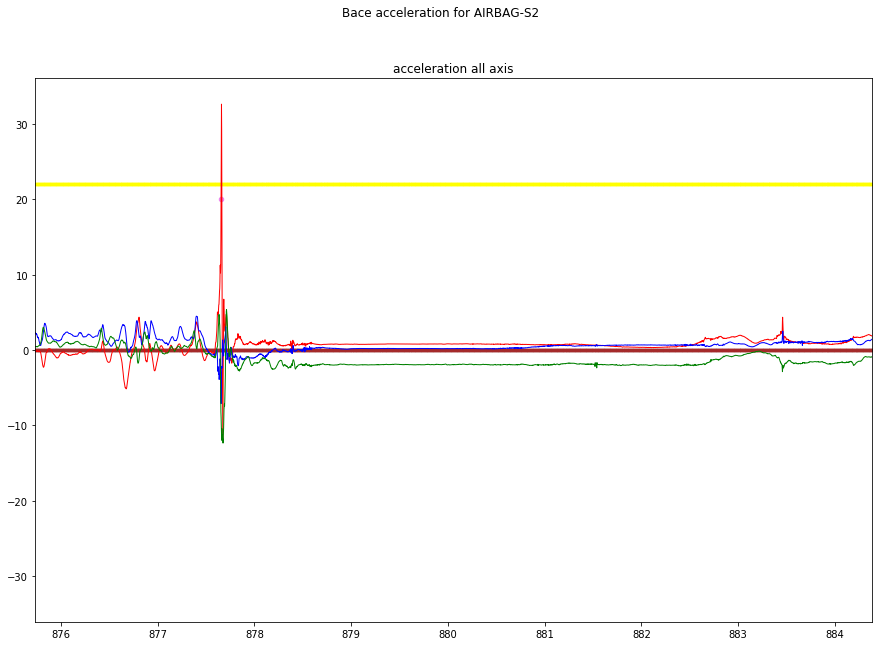

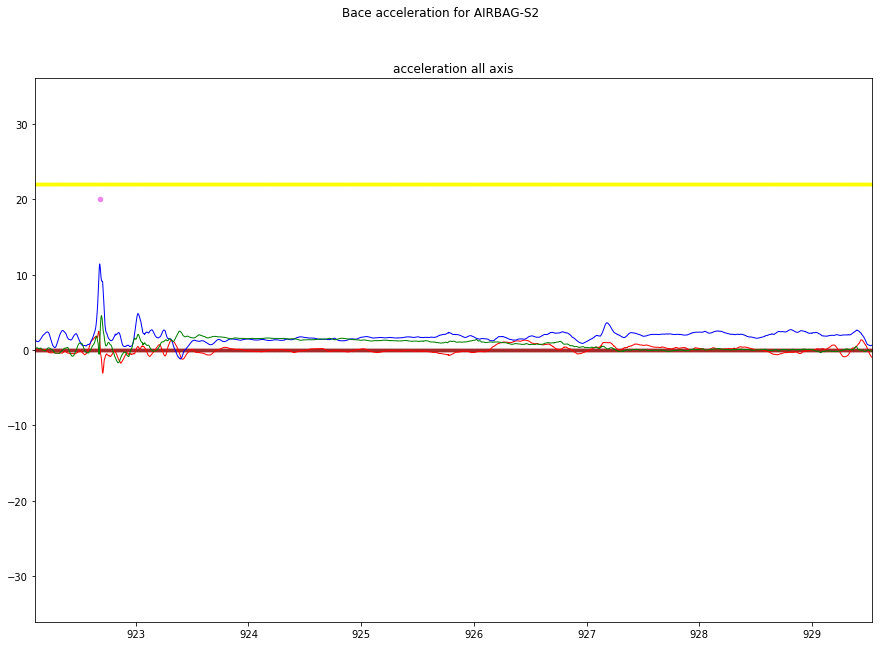

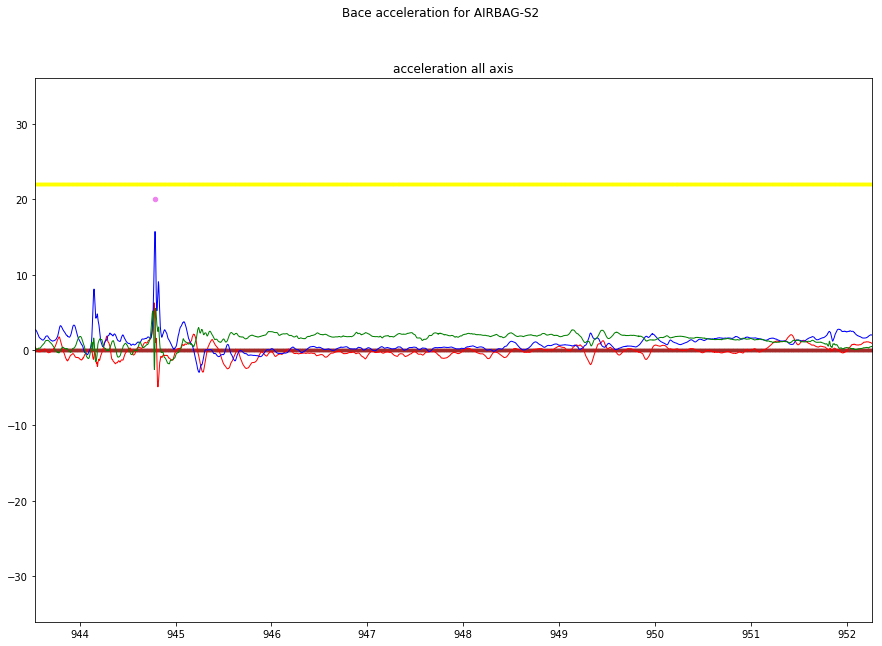

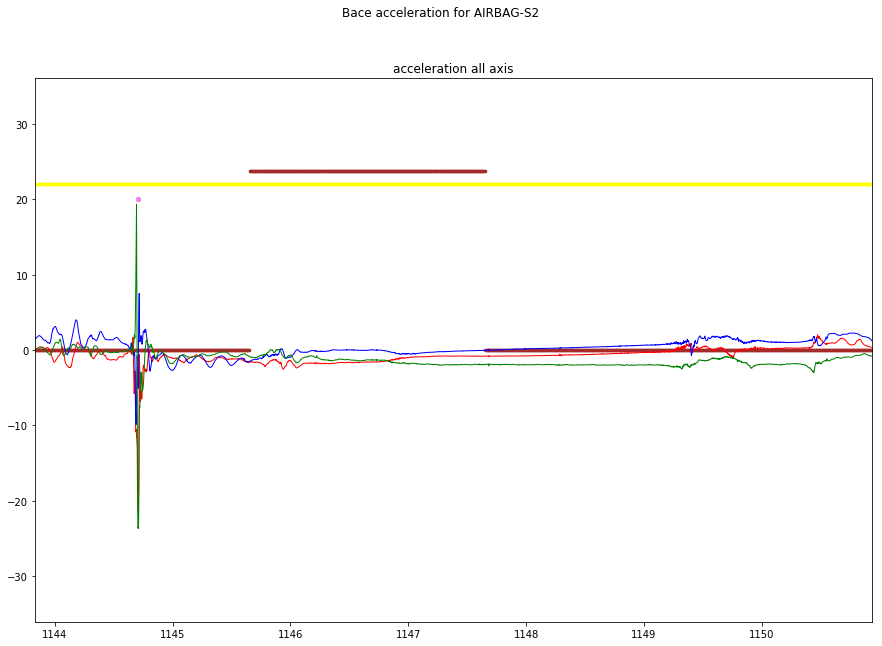

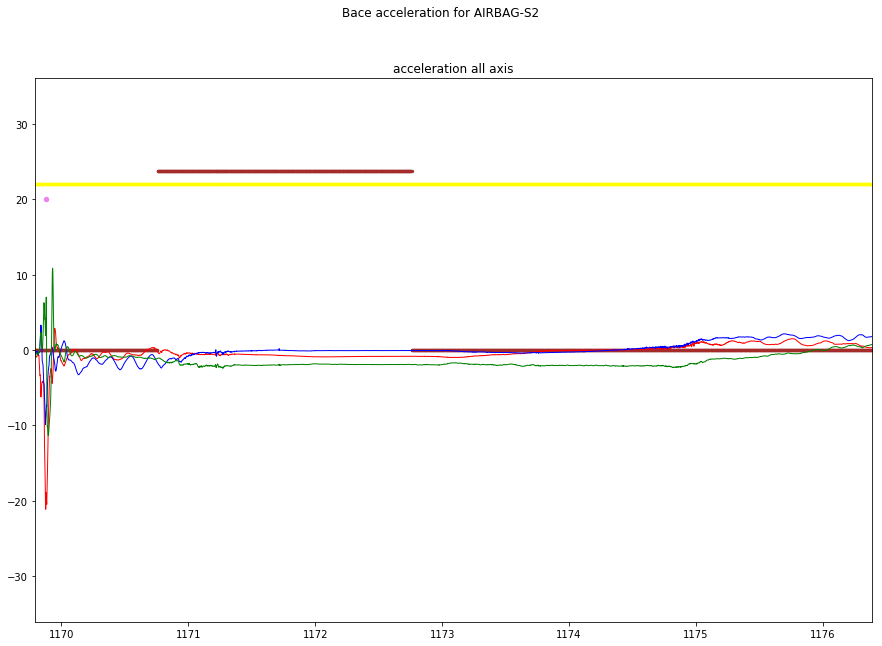

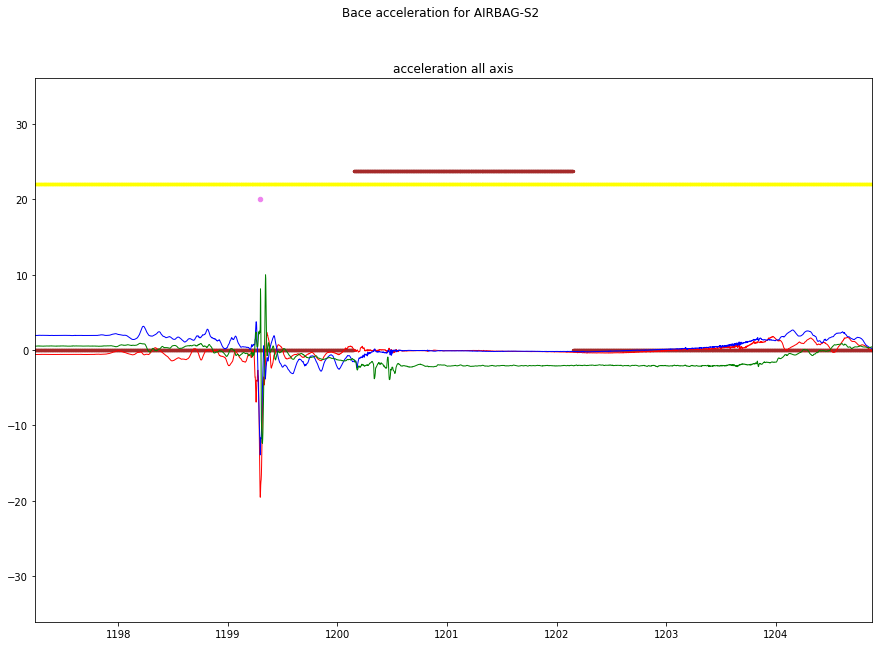

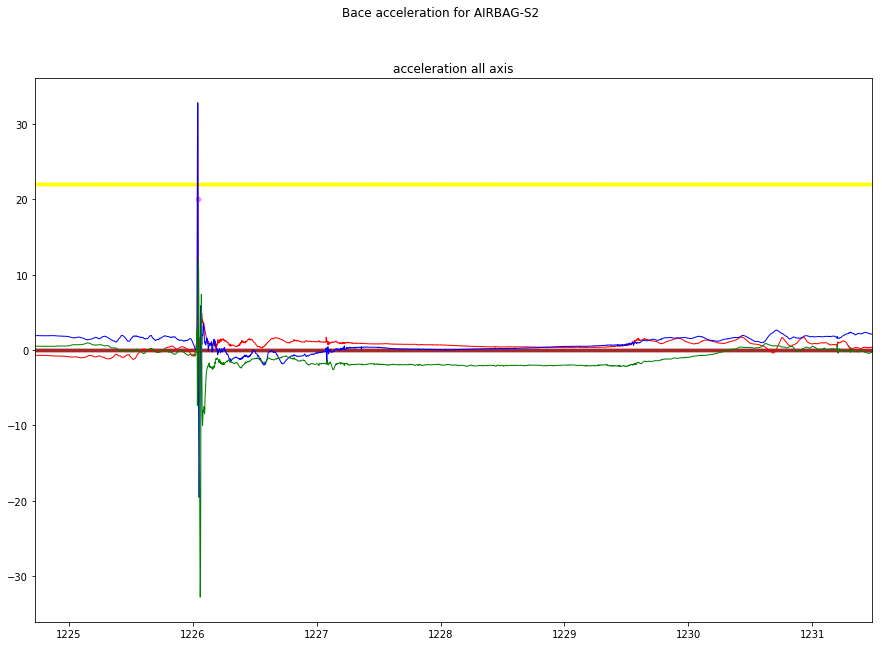

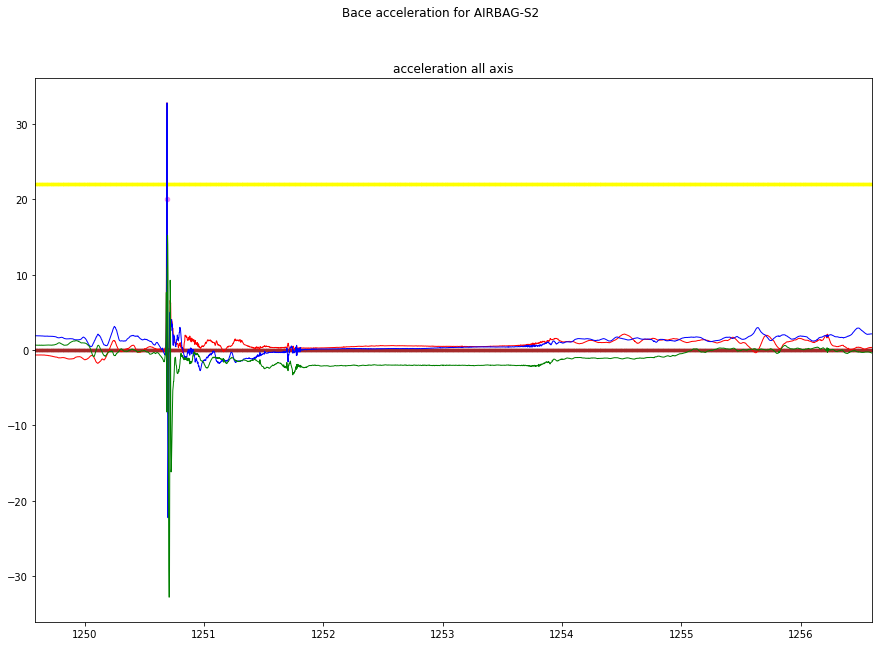

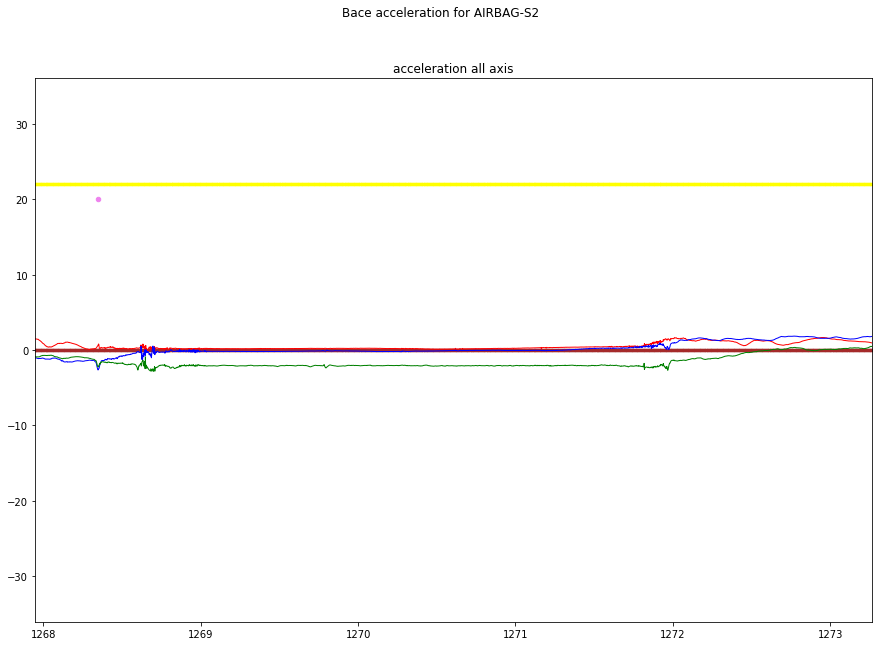

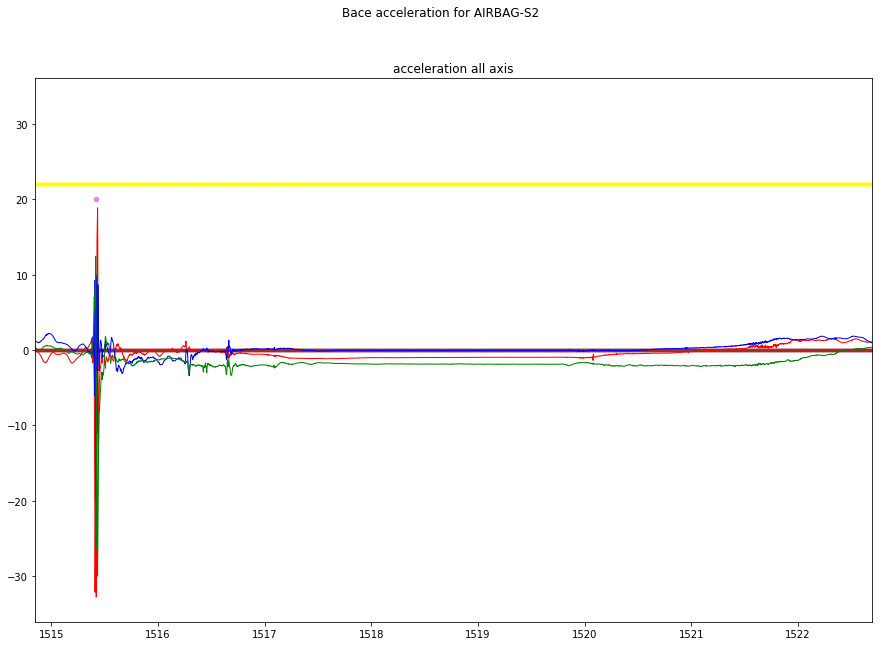

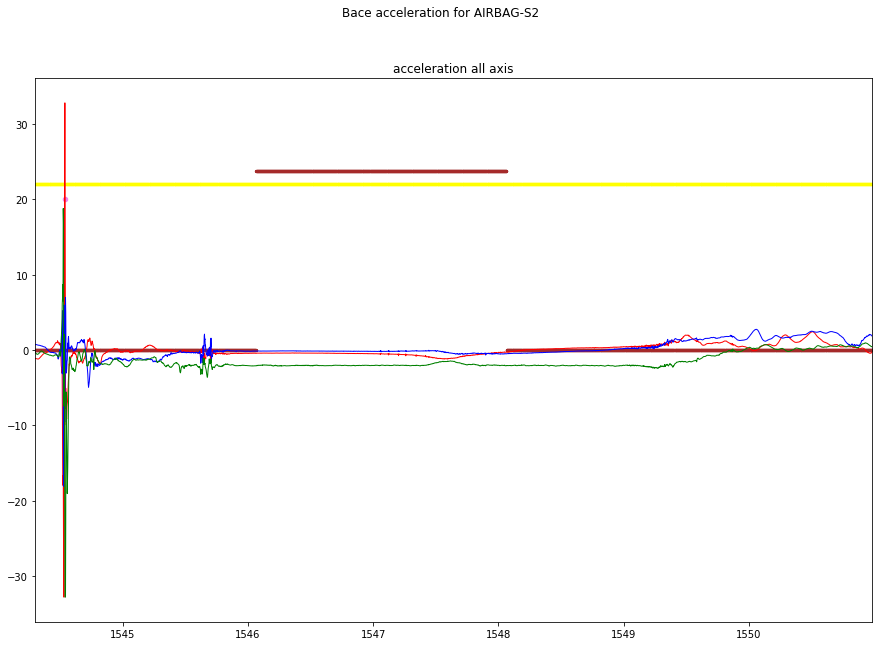

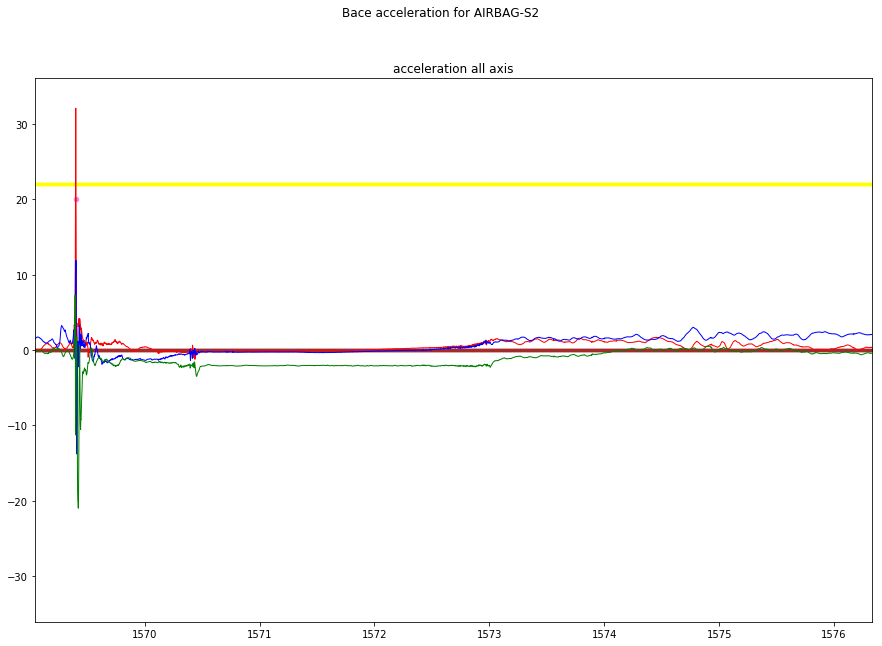

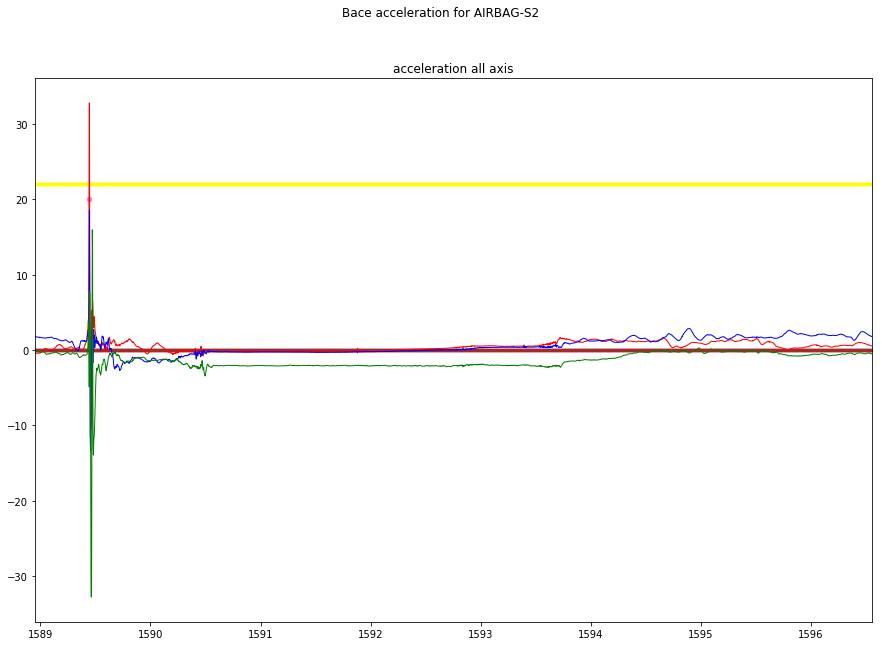

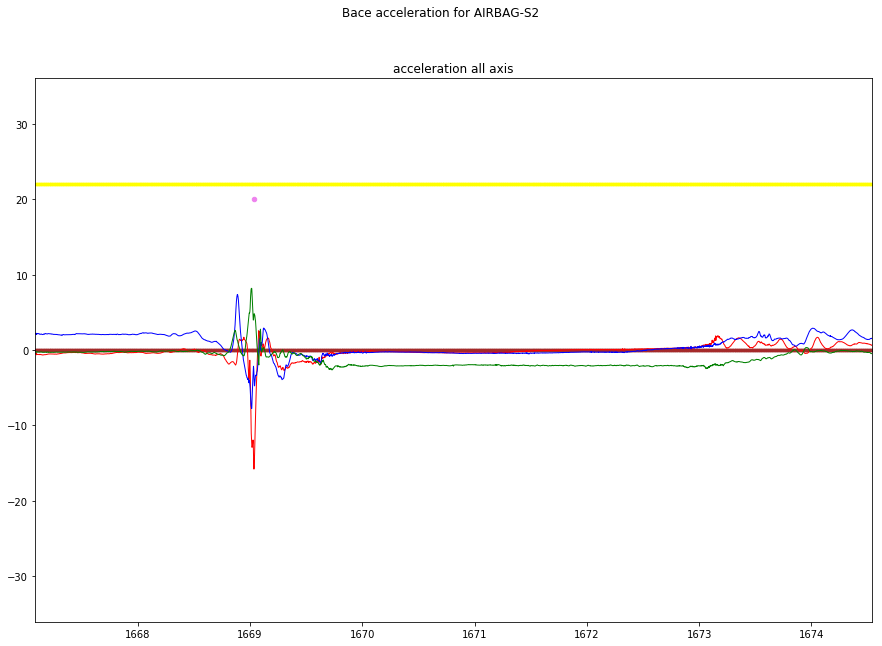

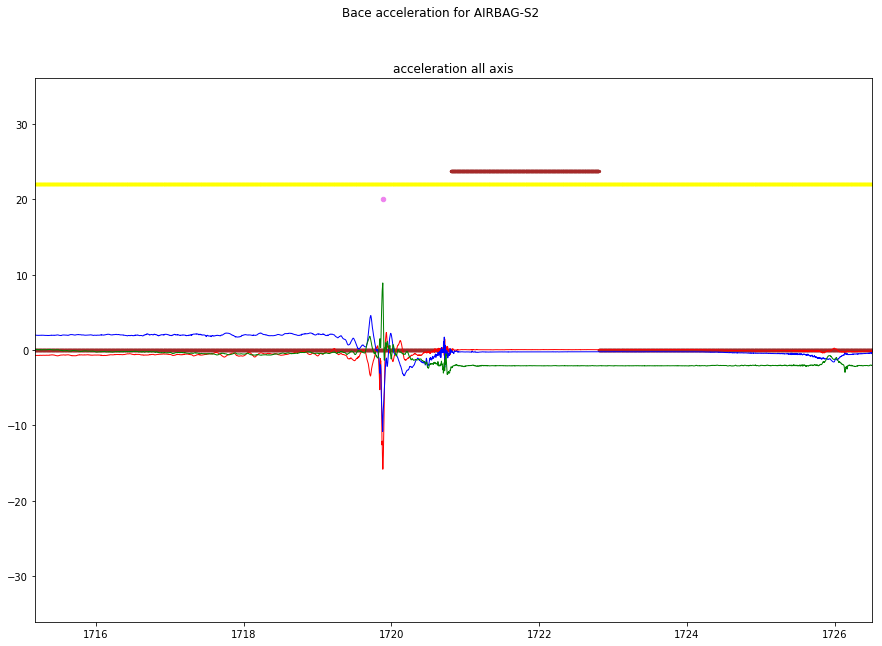

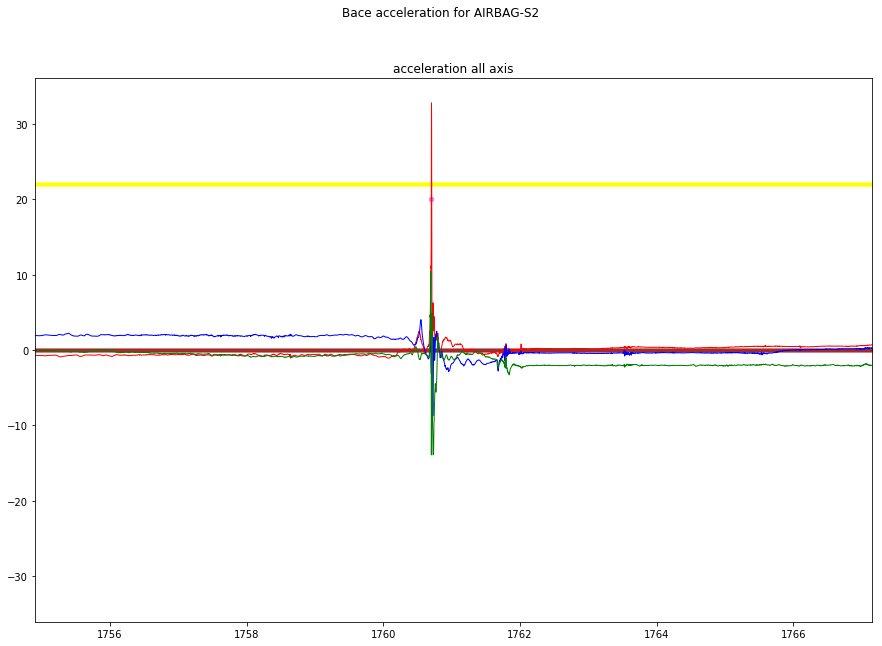

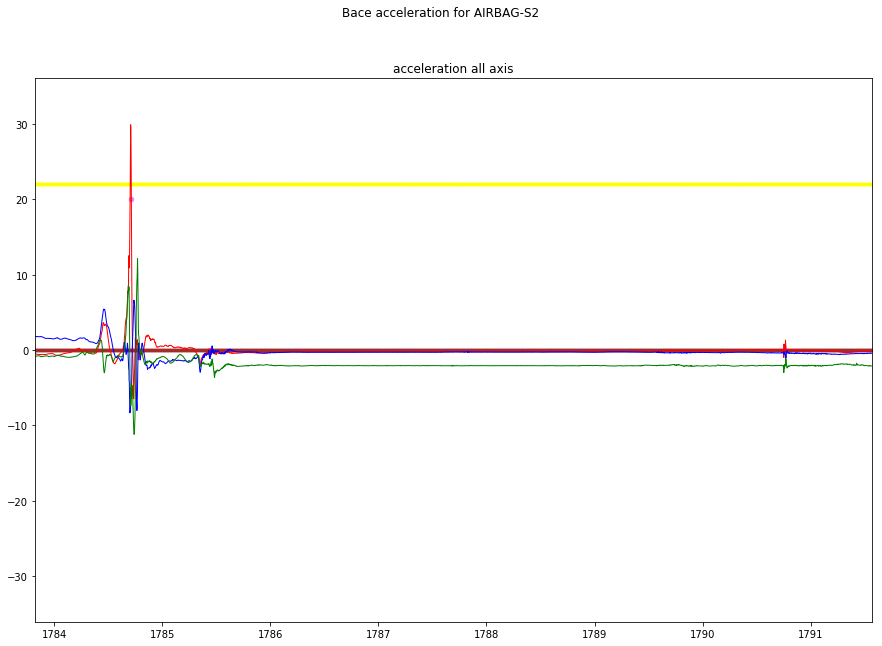

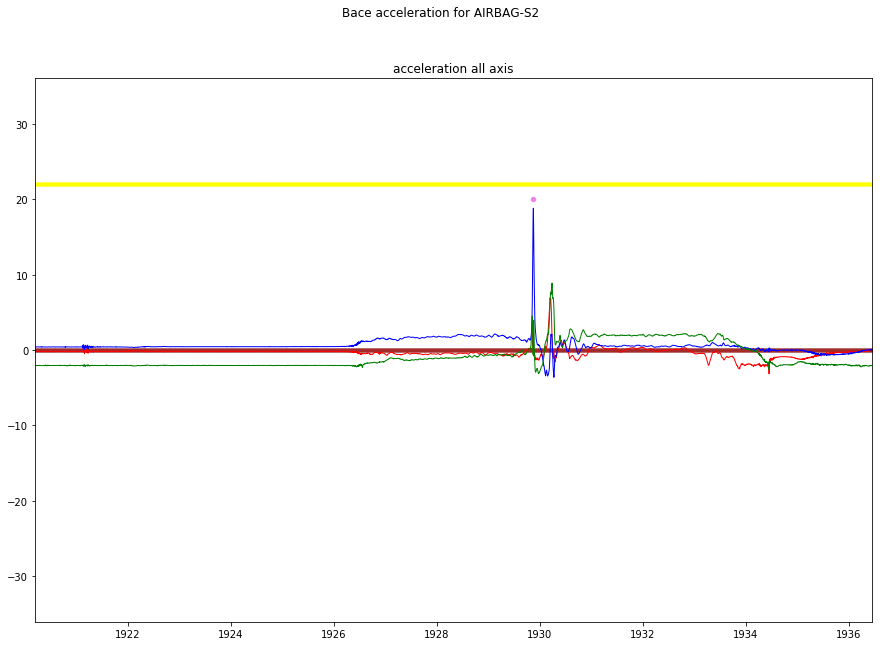

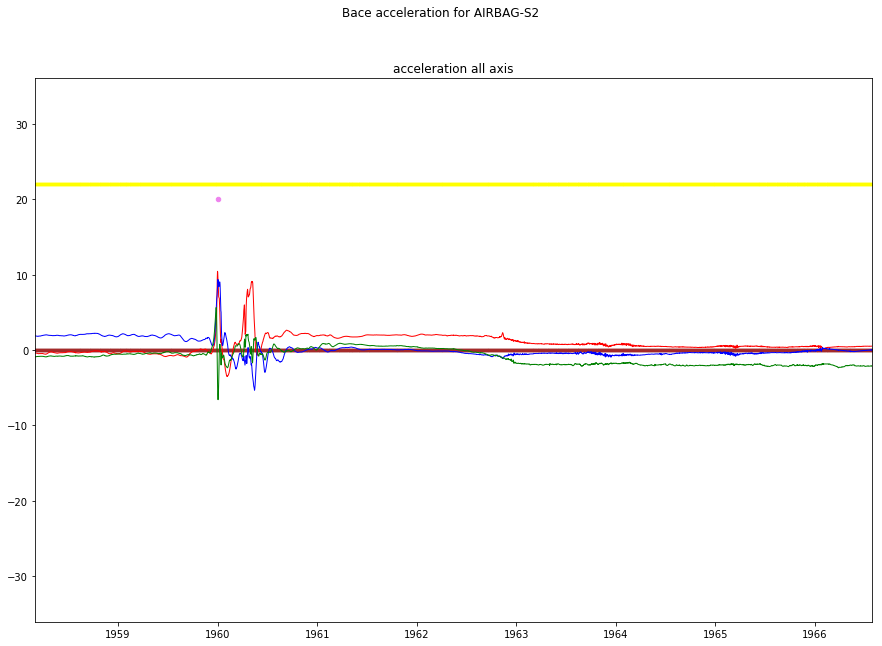

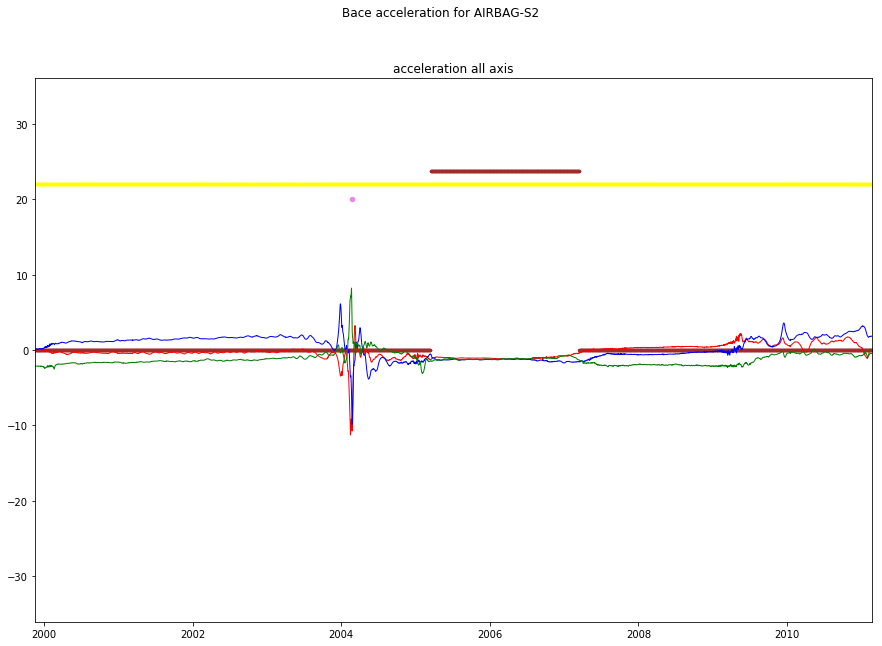

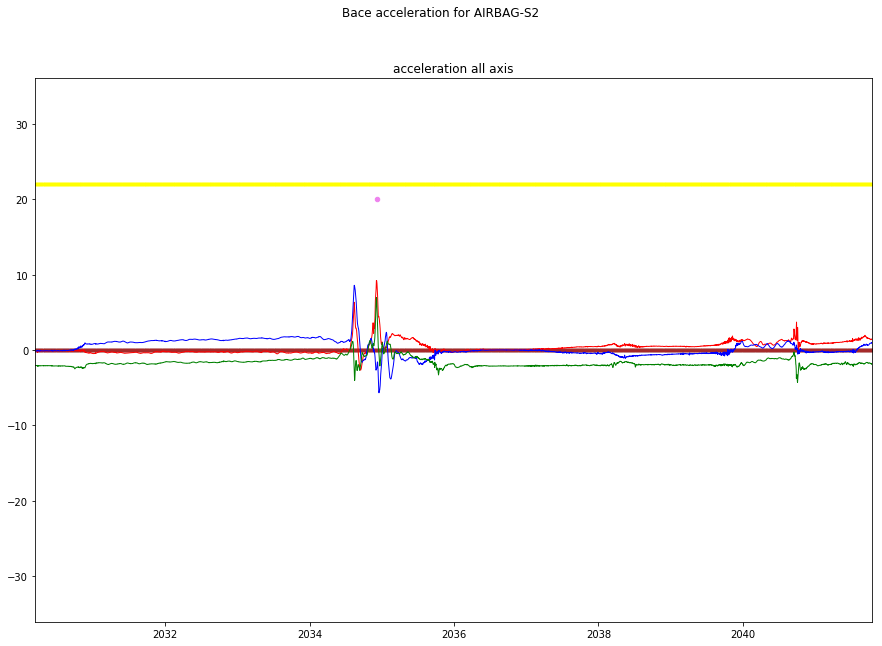

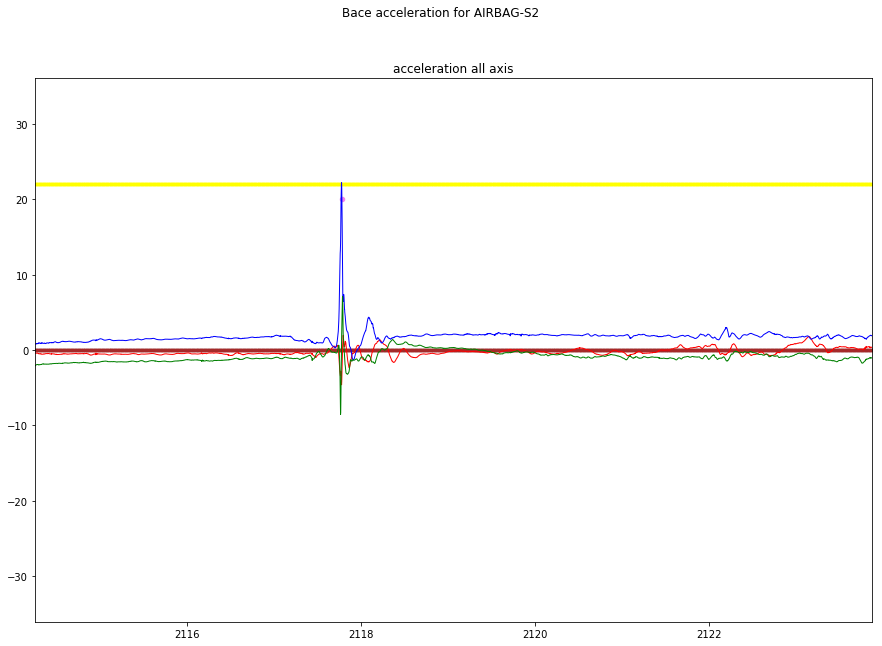

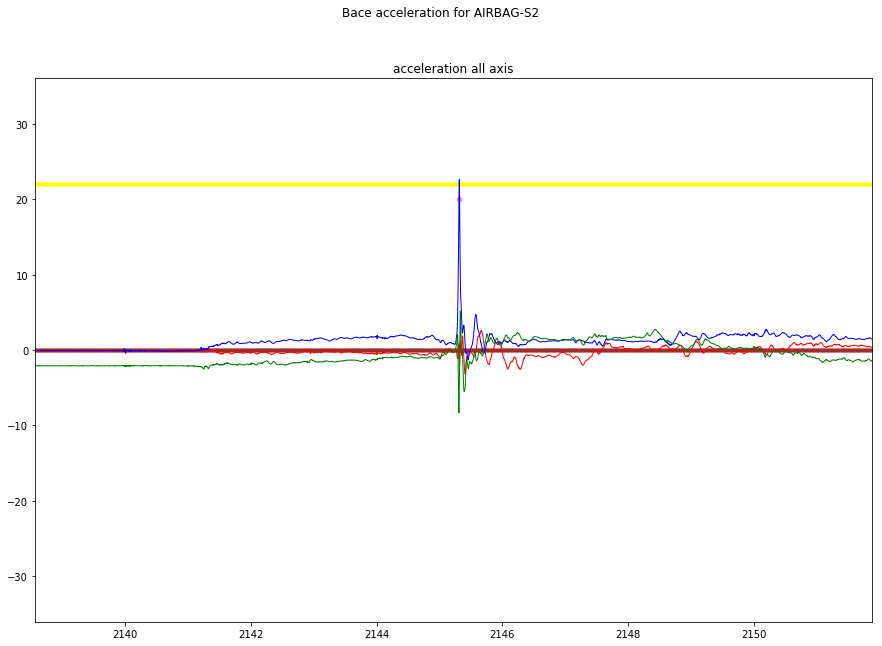

In [16]:
for index, row in s2_combined.iterrows():
    big_size_plot_of_acceleration_vs_time(data=s2_data,label='S2',left=row['Start milisec']*(10**(-3)),
                                          right= row['End Milisec']*(10**(-3)))

# For - S3

In [34]:
s3_data=read_data('Airbag-S3.CSV')
s3_combined = read_combined_data('S3-combined.xlsx',s3_data)
add_new_fall_value(s3_data,s3_combined)

    cal_impact_value  impact_value   difference_in_min
0          11.095233     11.099483           -0.004250
1          11.566433     11.574600           -0.008167
2          13.964667     13.974233           -0.009567
3          14.508700     14.518000           -0.009300
4          15.314967     15.305217            0.009750
5          15.791233     15.795350           -0.004117
6          19.209433     19.220150           -0.010717
7          19.828633     19.839417           -0.010783
8          20.589300     20.601117           -0.011817
9          21.096933     21.104467           -0.007533
10         21.794567     21.806167           -0.011600
11         22.292100     22.293633           -0.001533
12         22.767133     22.773600           -0.006467
13         23.164233     23.165450           -0.001217
14         27.139200     27.145133           -0.005933
15         27.477633     27.481800           -0.004167
16         28.892833     28.901917           -0.009083
17        

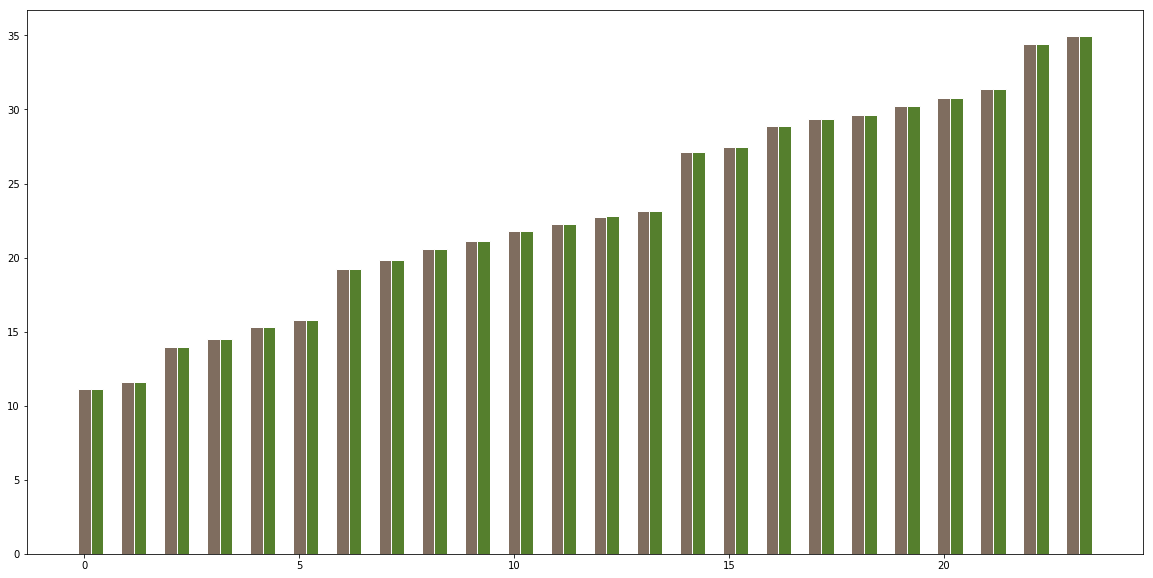

In [56]:
plot_offset(s3_data,s3_combined)

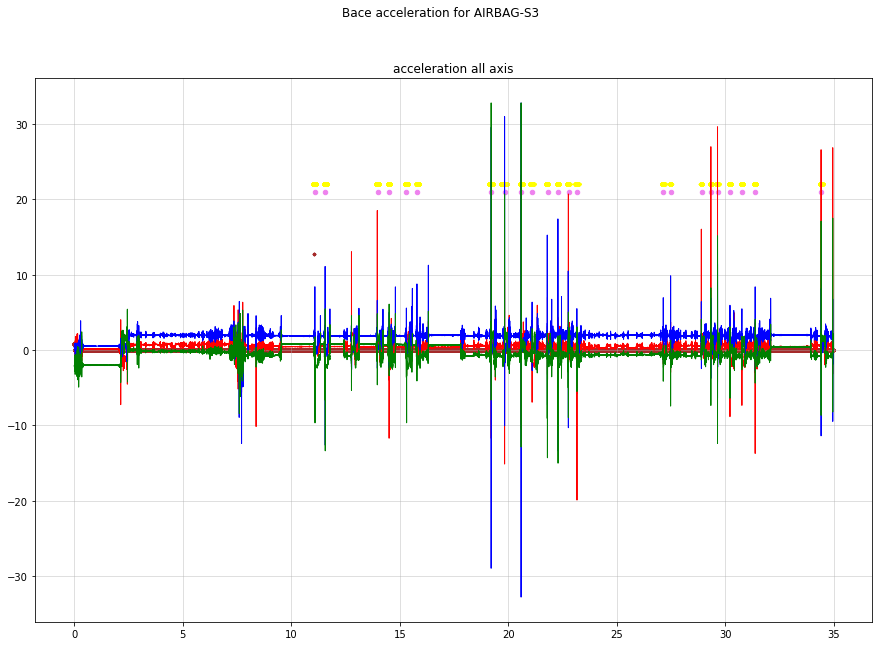

In [76]:
big_size_plot_of_acceleration_vs_time(data=s3_data,label='S3')

C:\Users\hp\Anaconda3\envs\tensorflow_env\lib\site-packages\matplotlib\pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


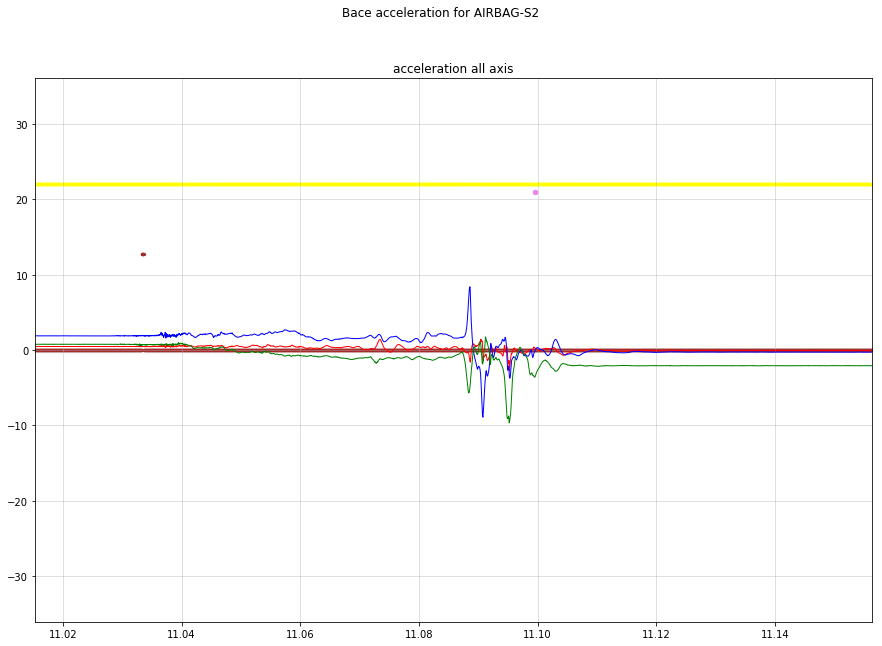

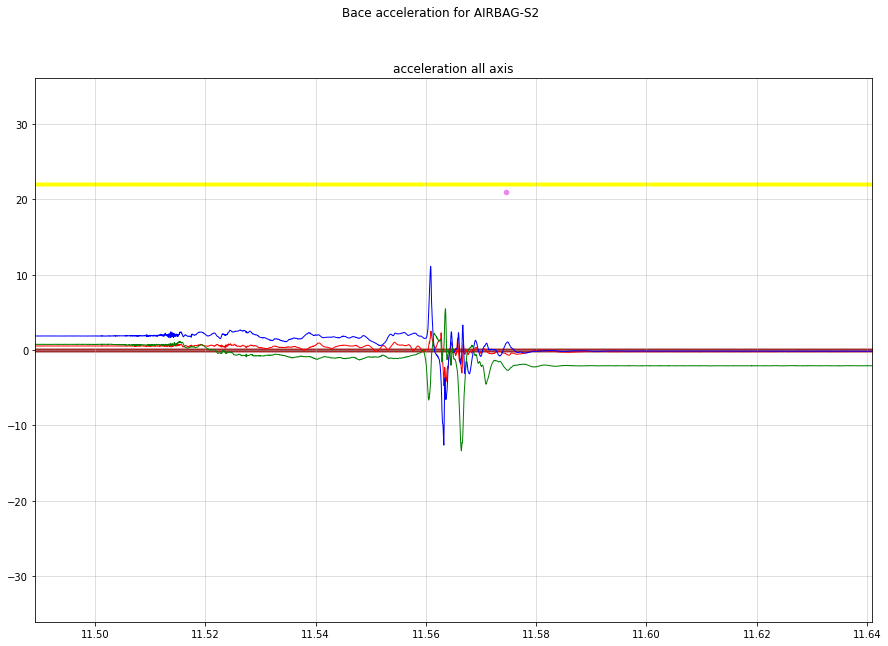

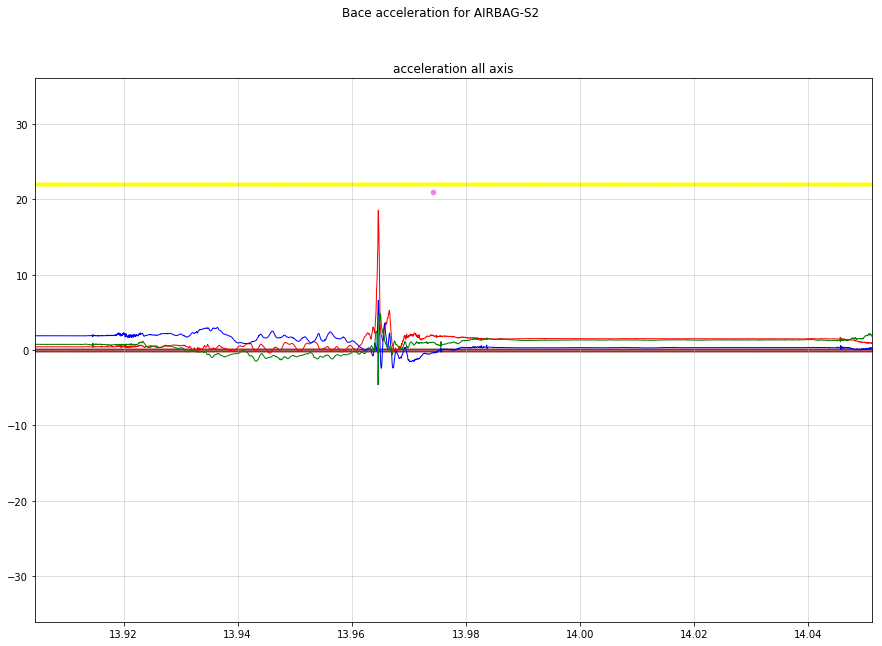

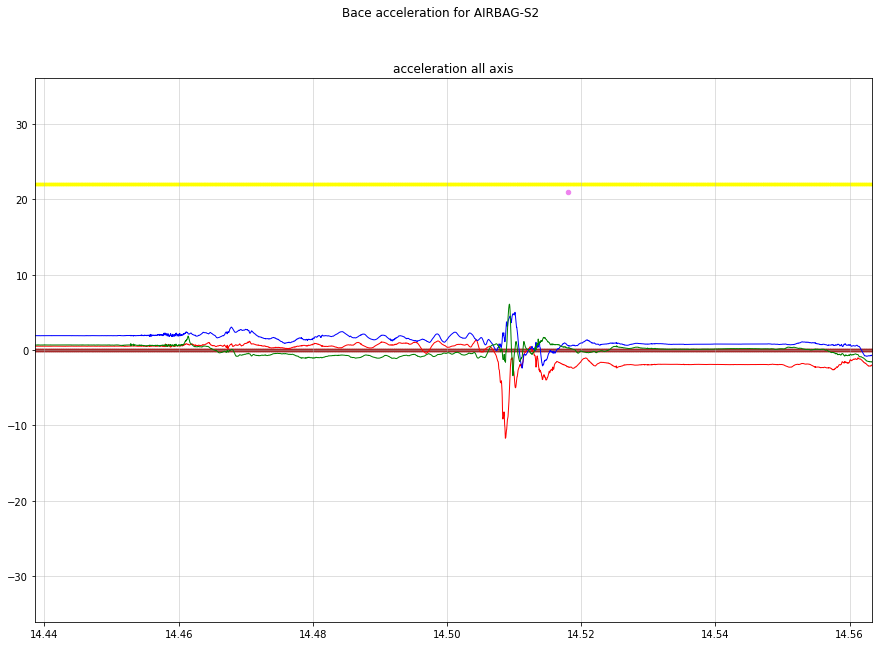

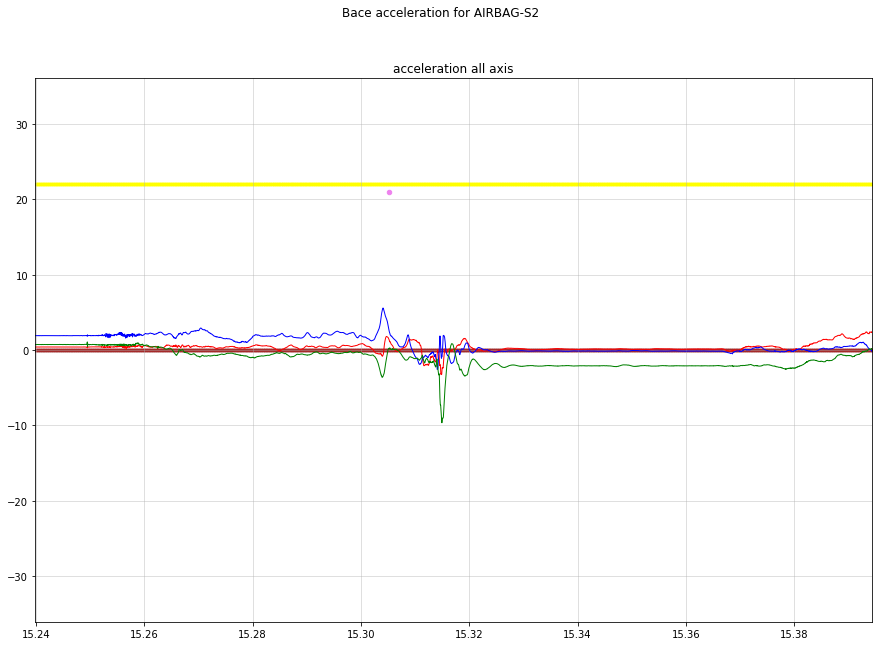

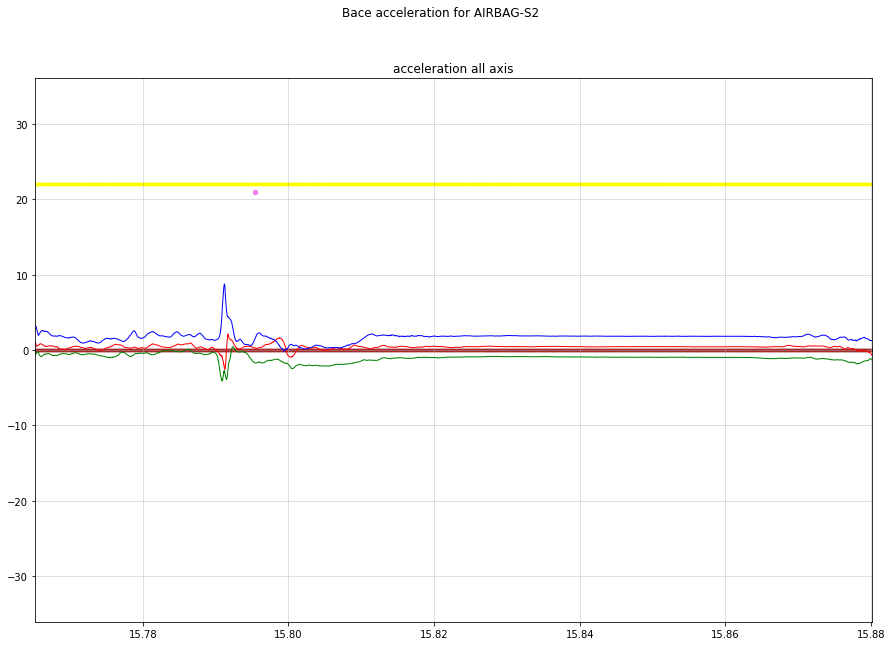

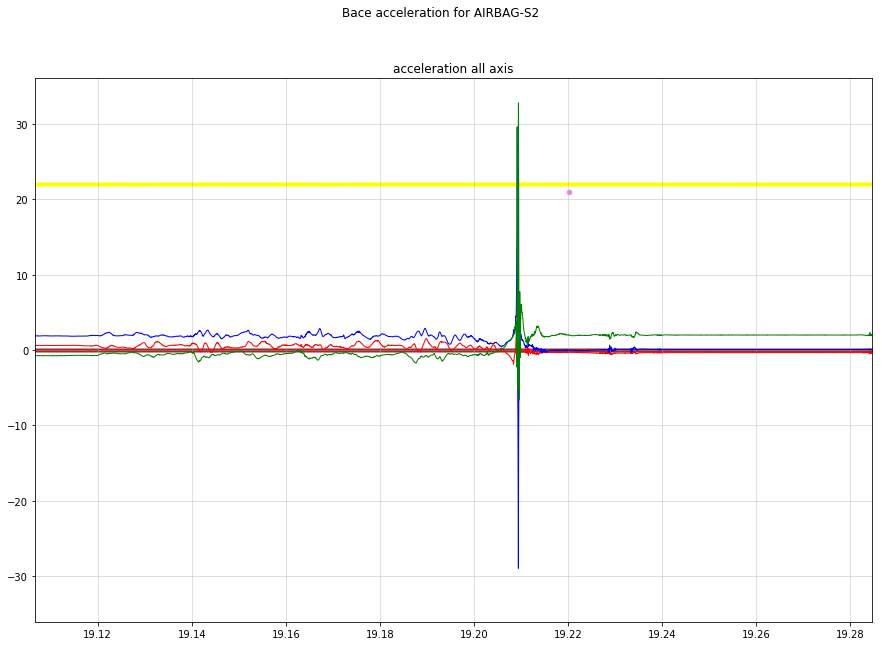

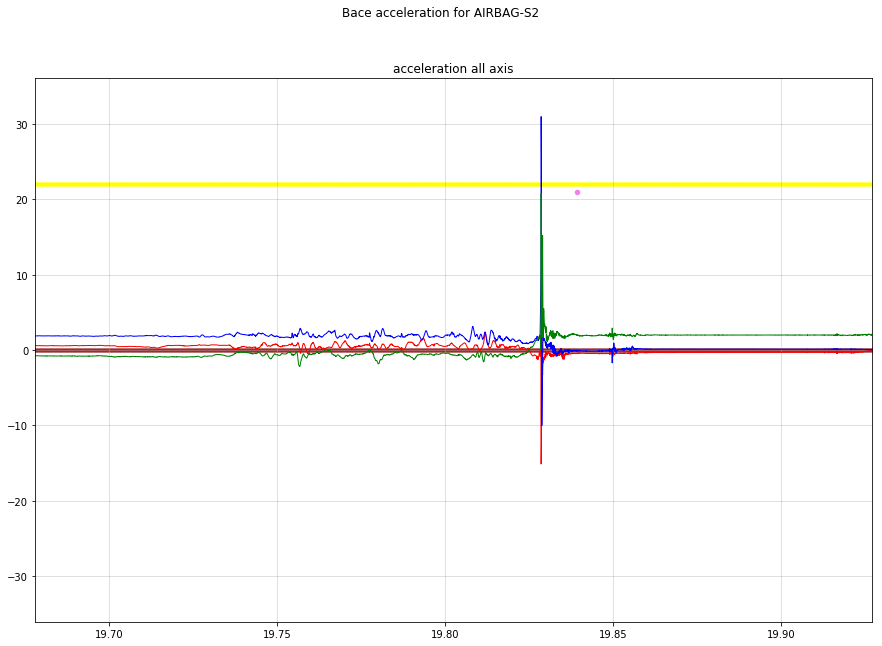

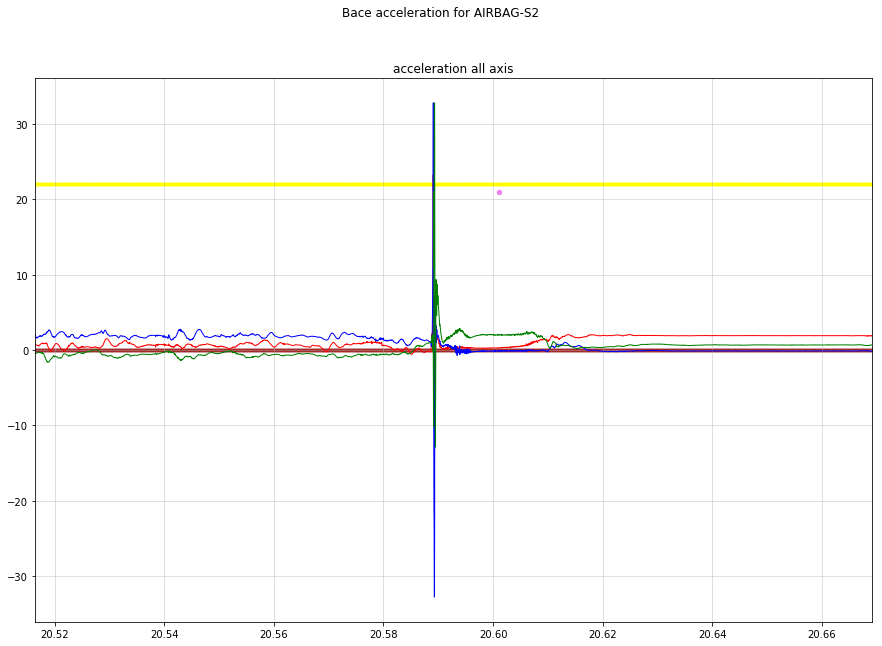

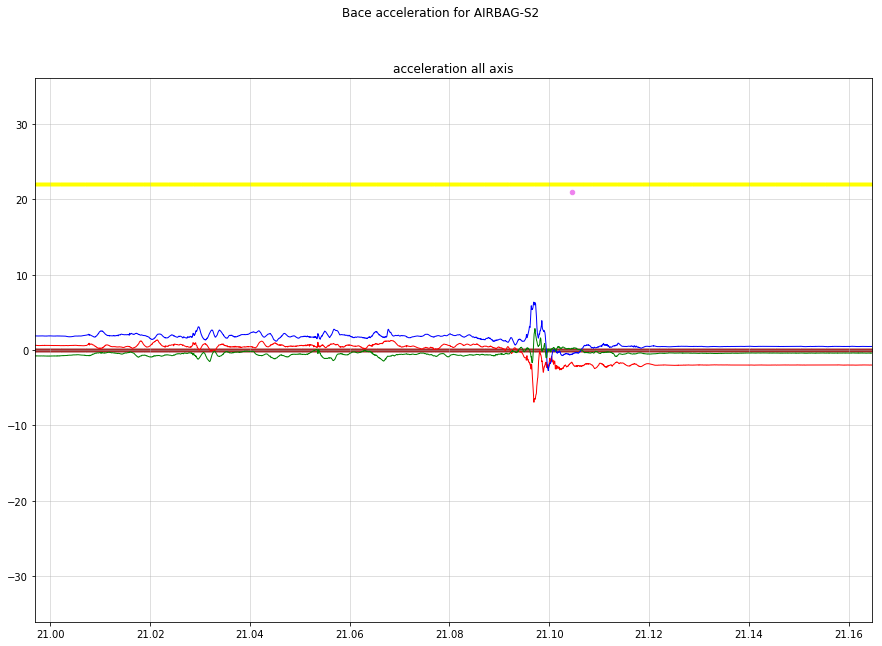

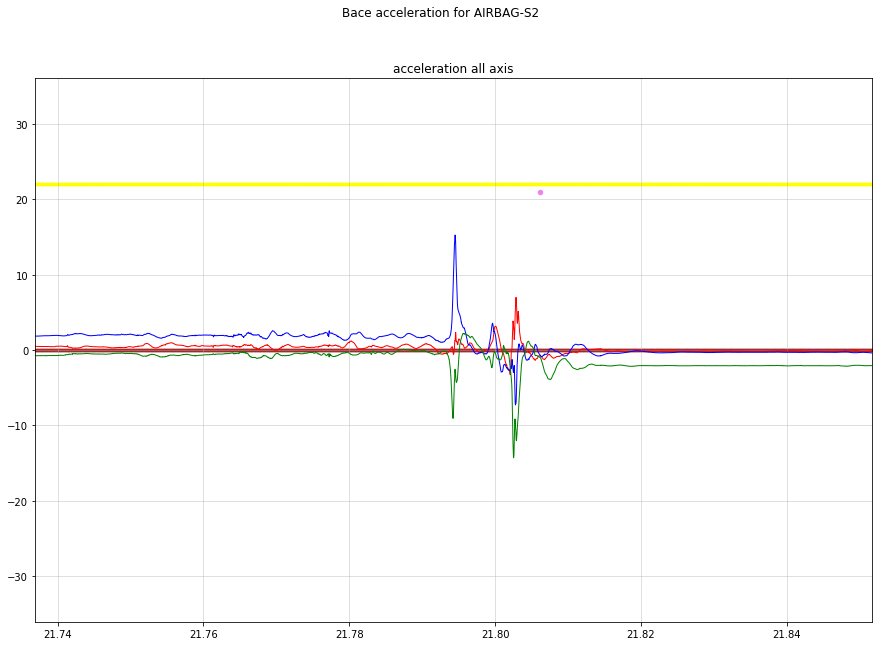

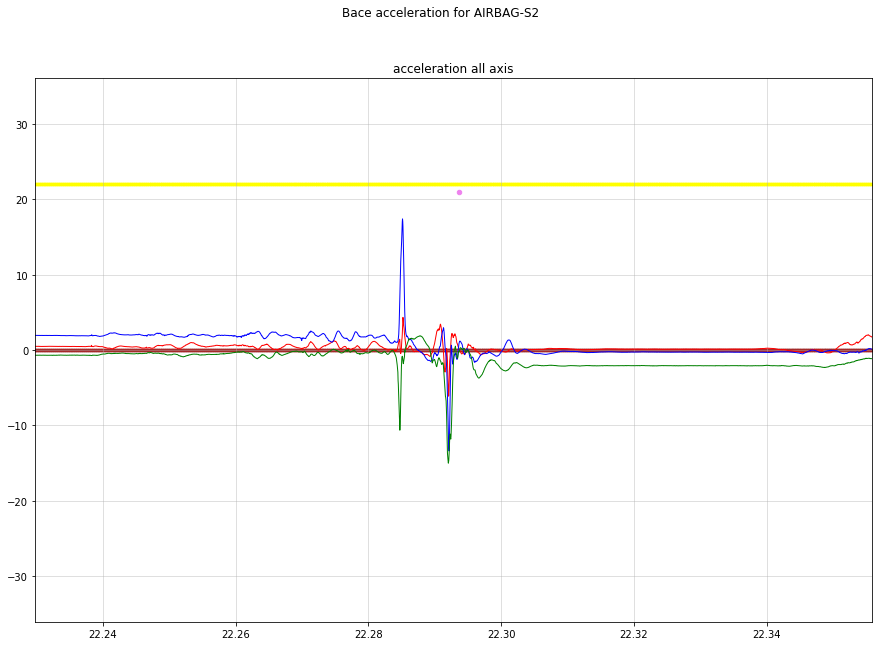

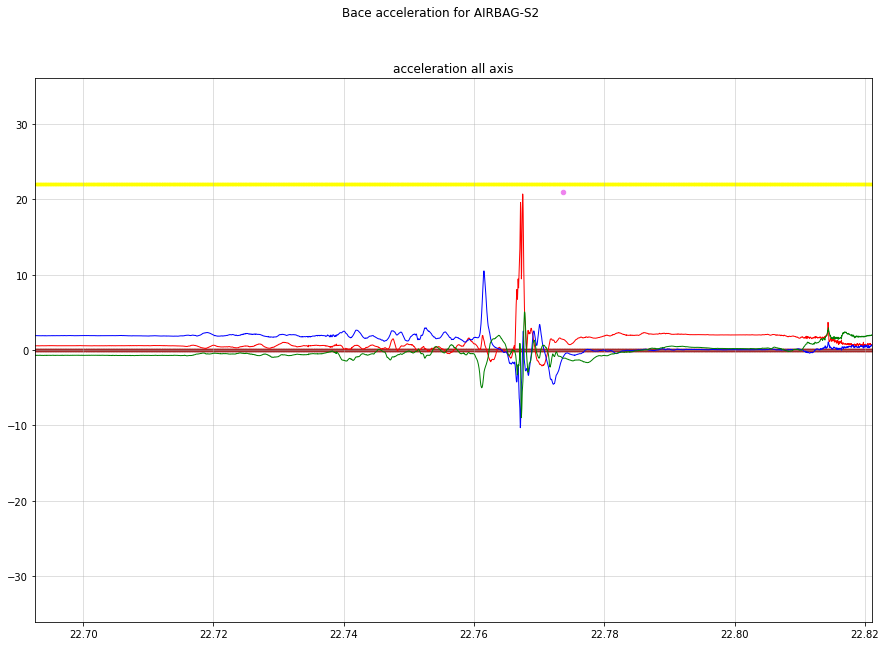

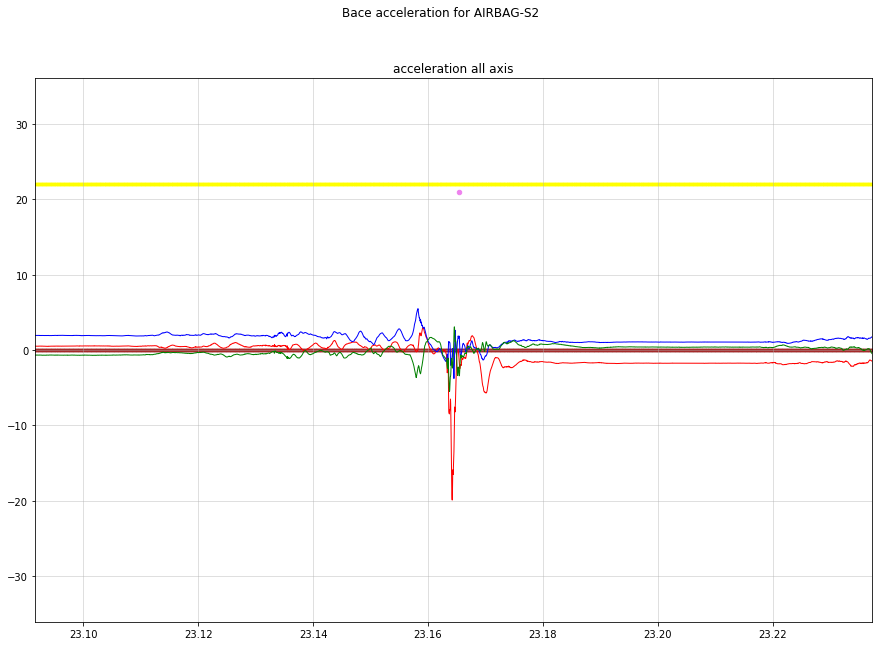

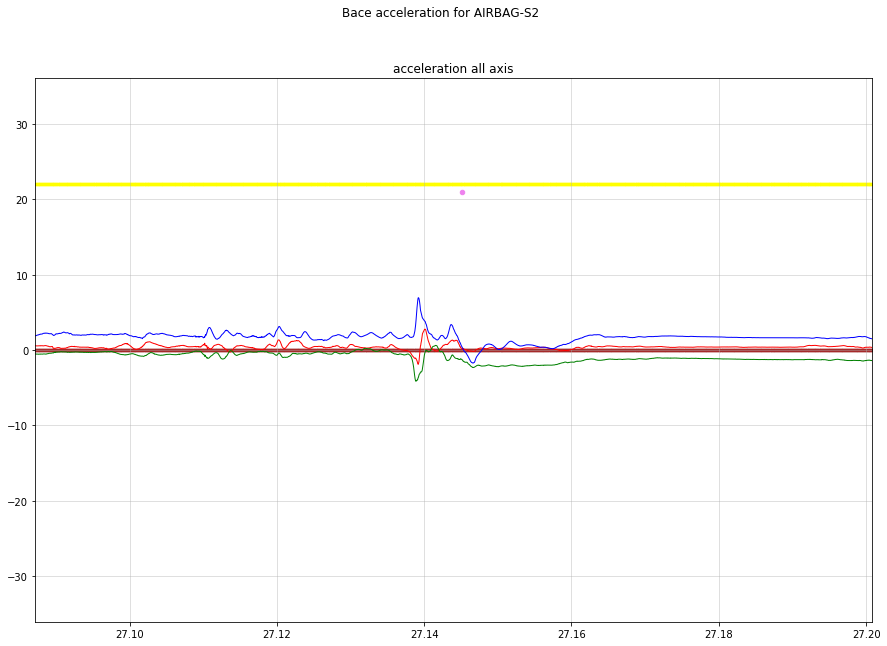

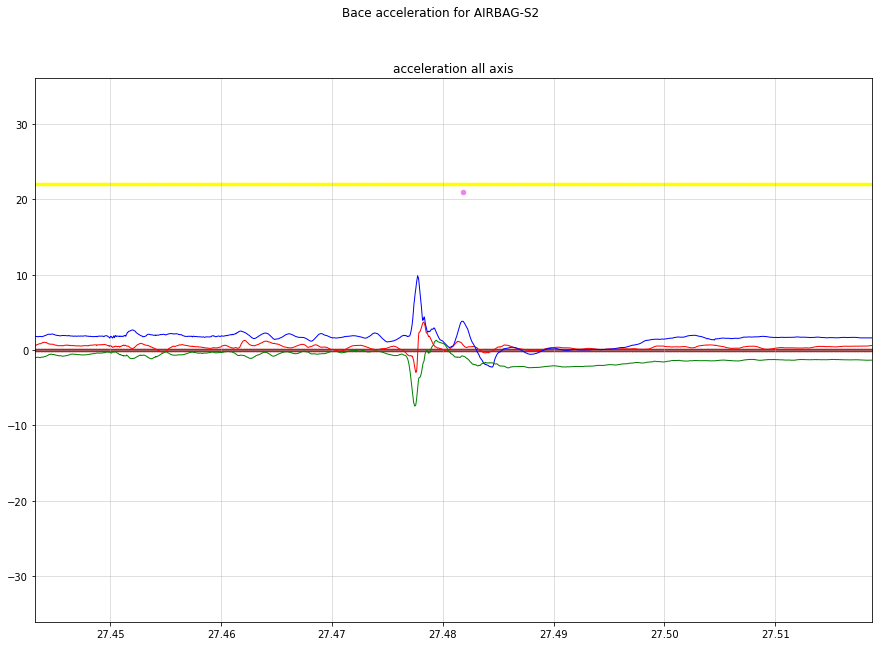

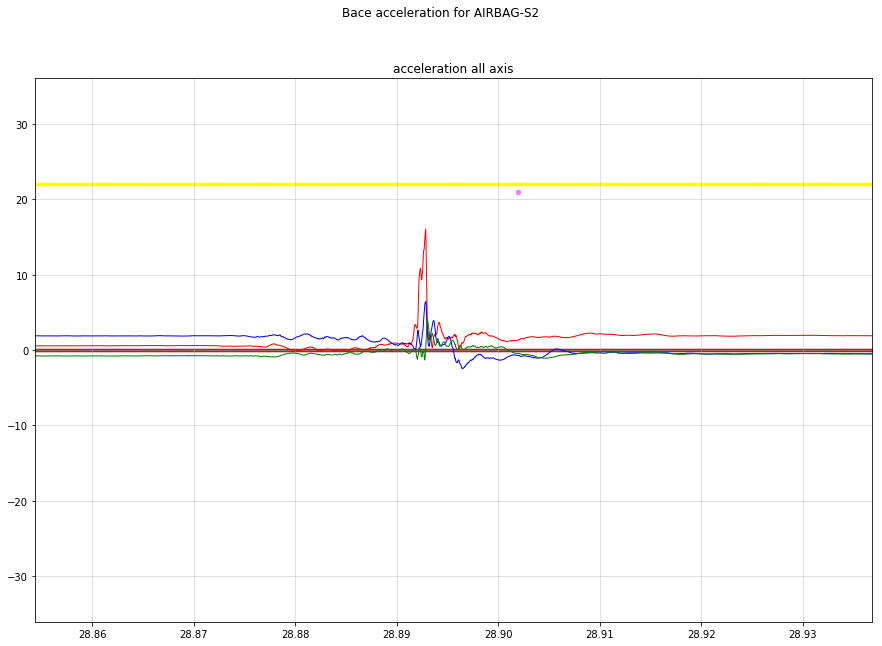

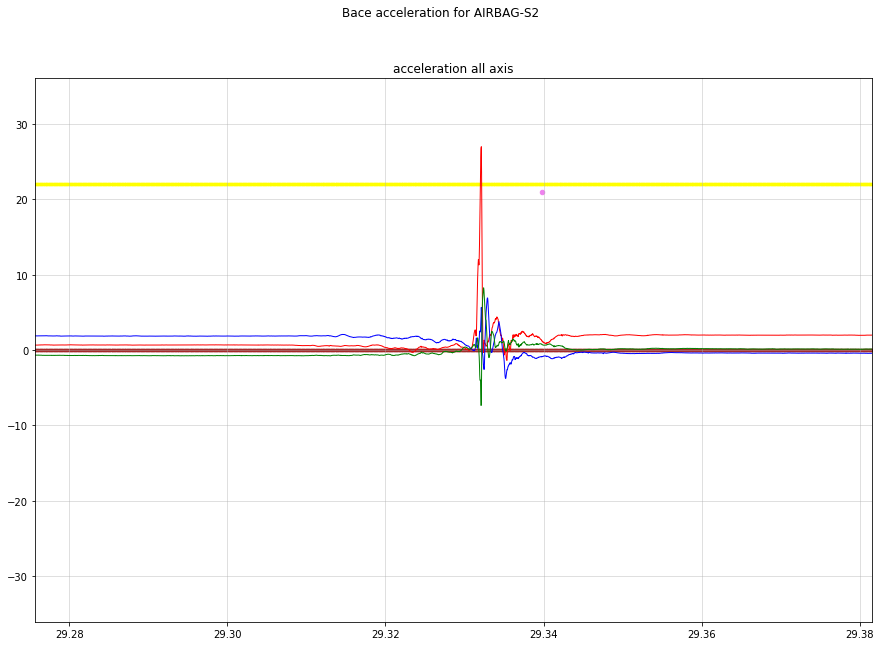

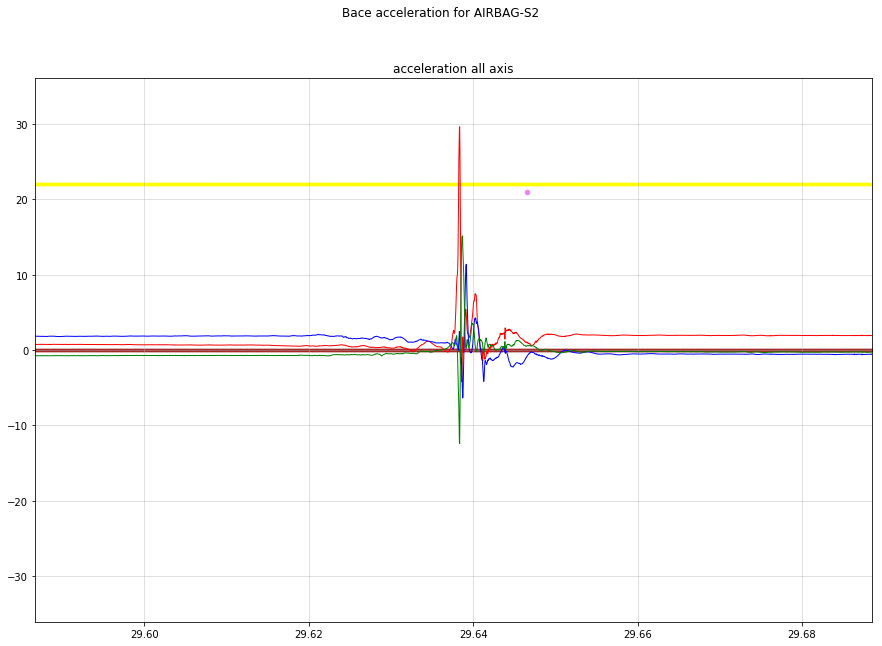

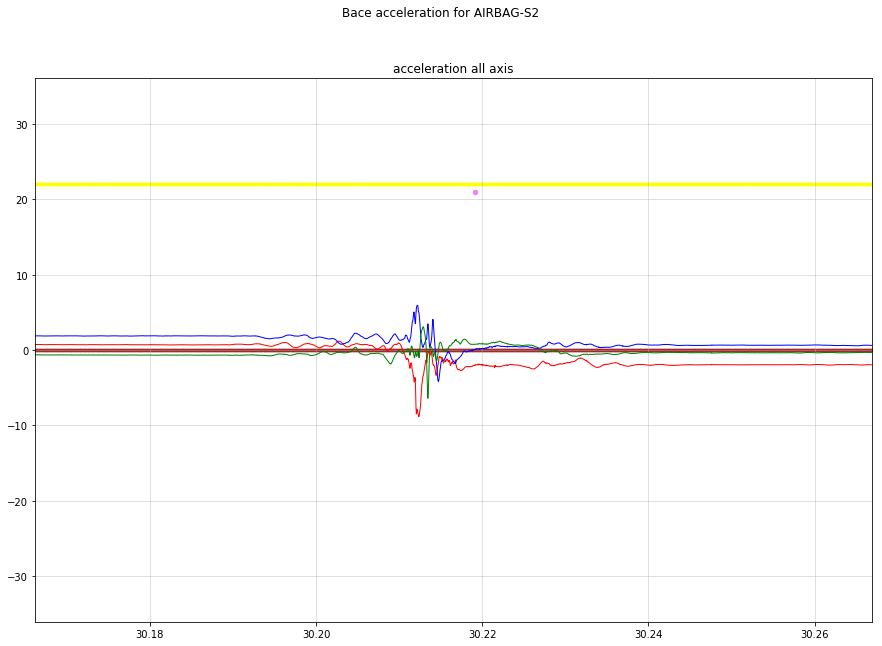

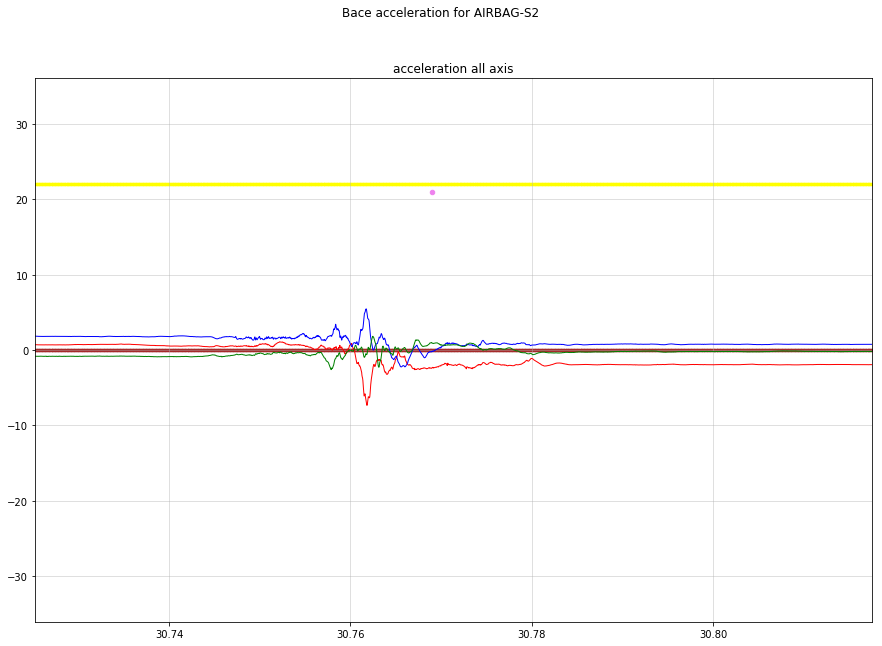

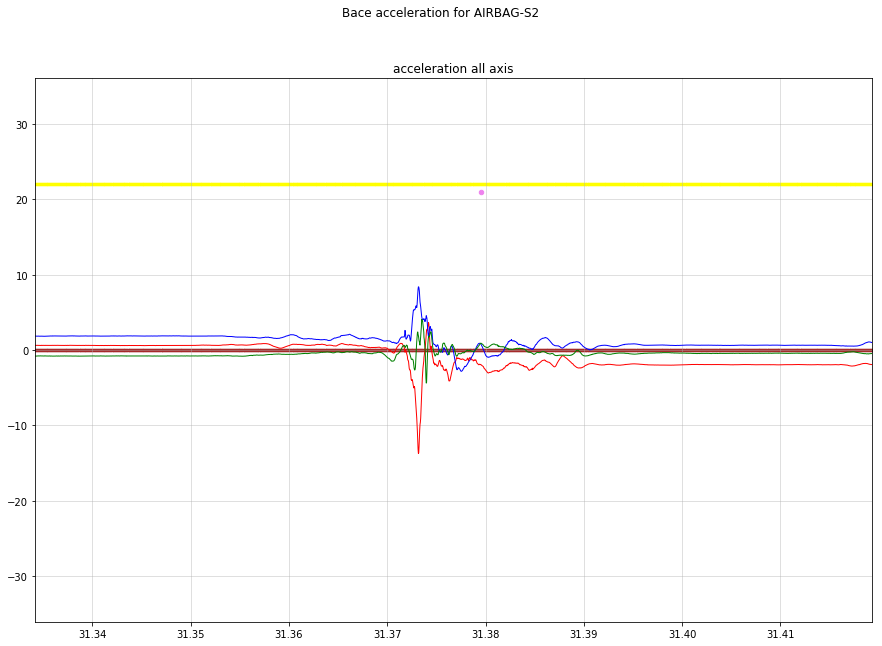

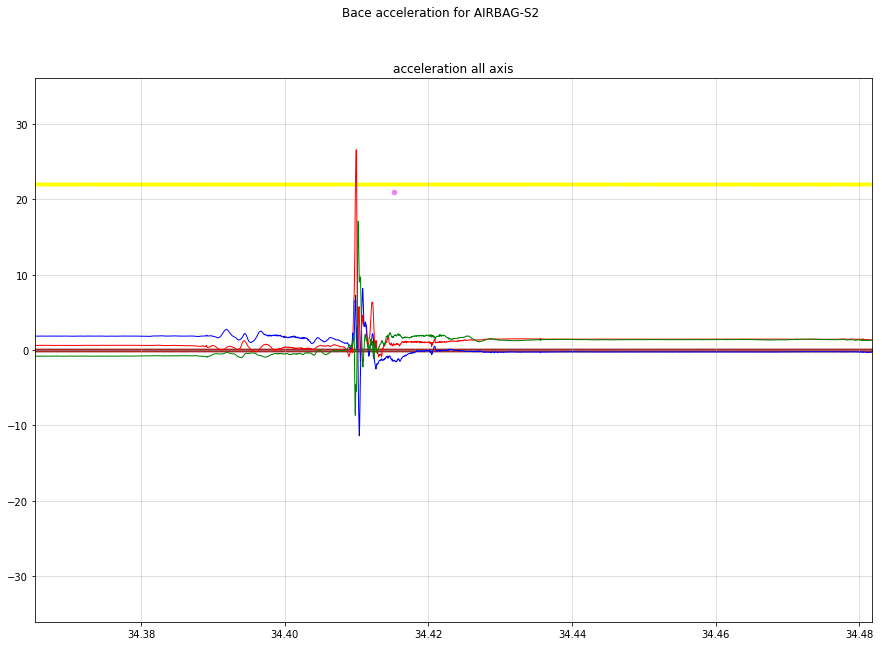

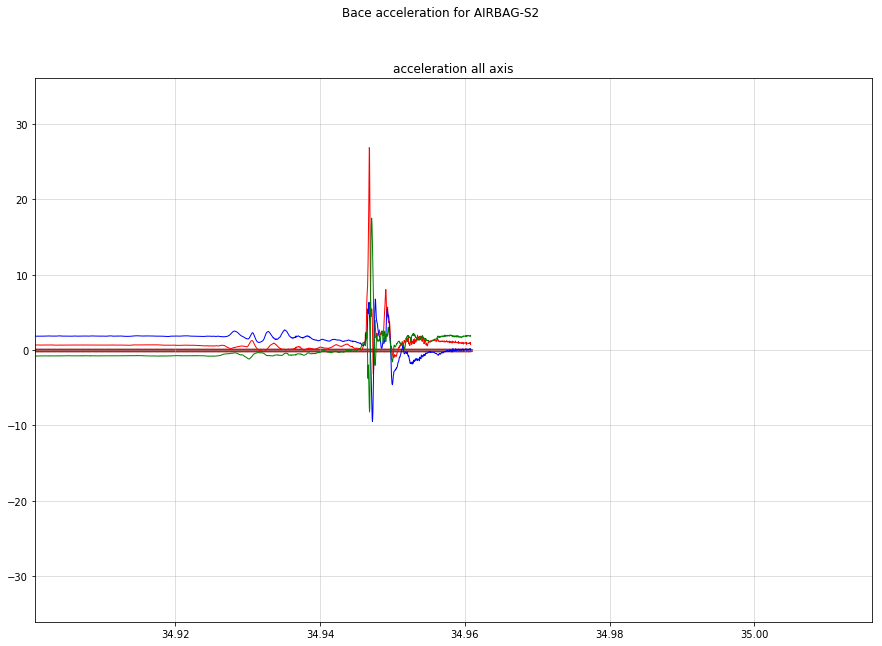

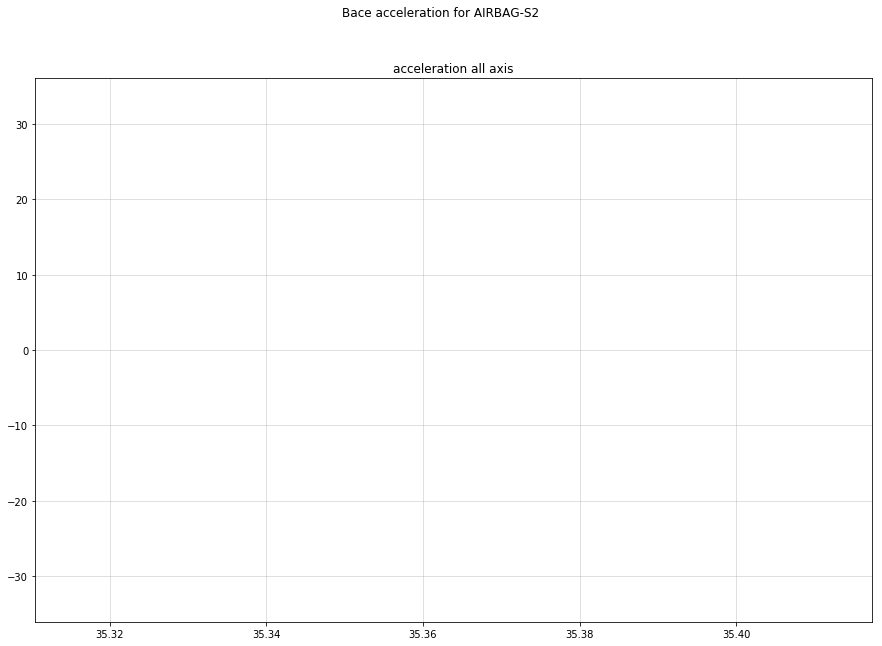

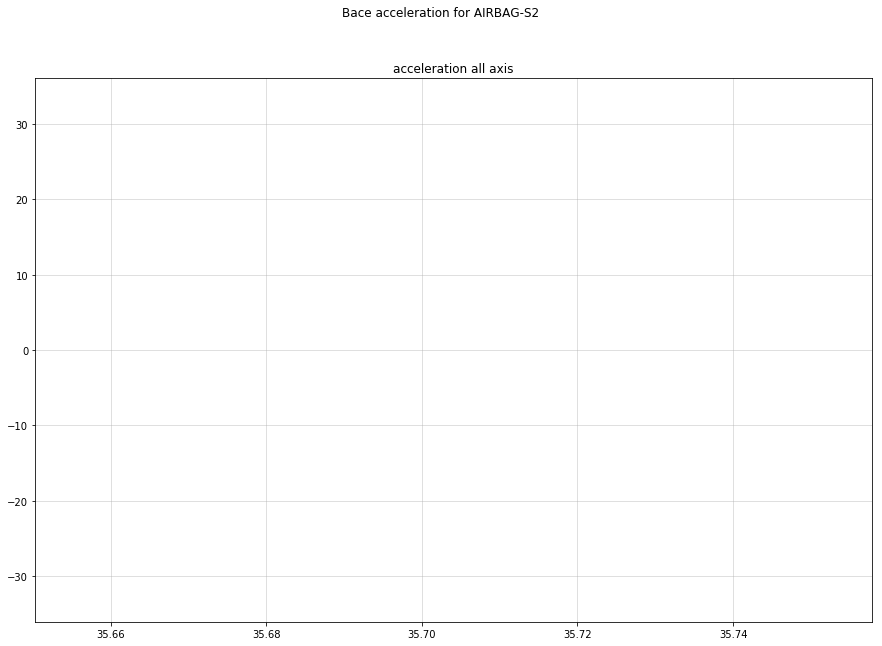

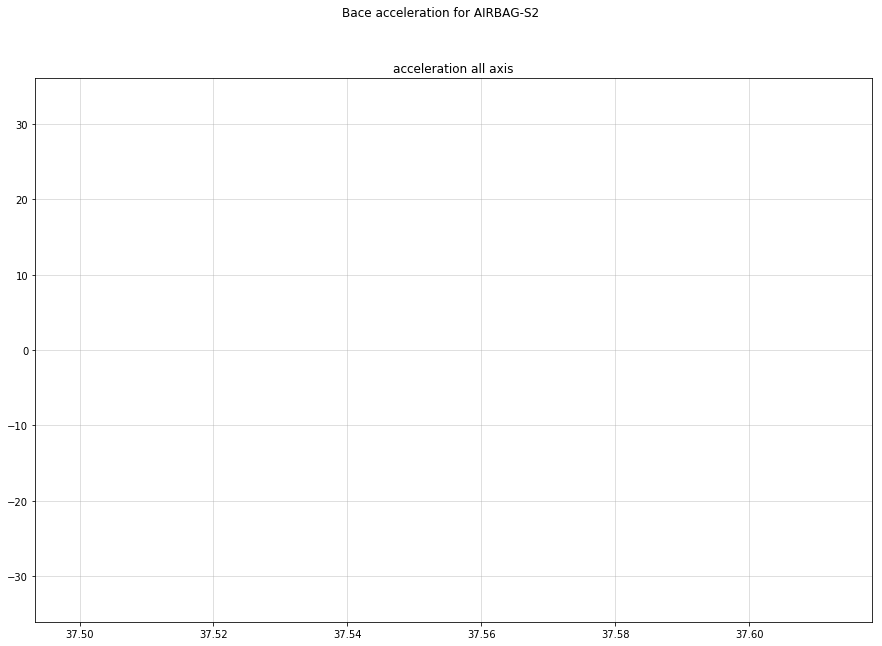

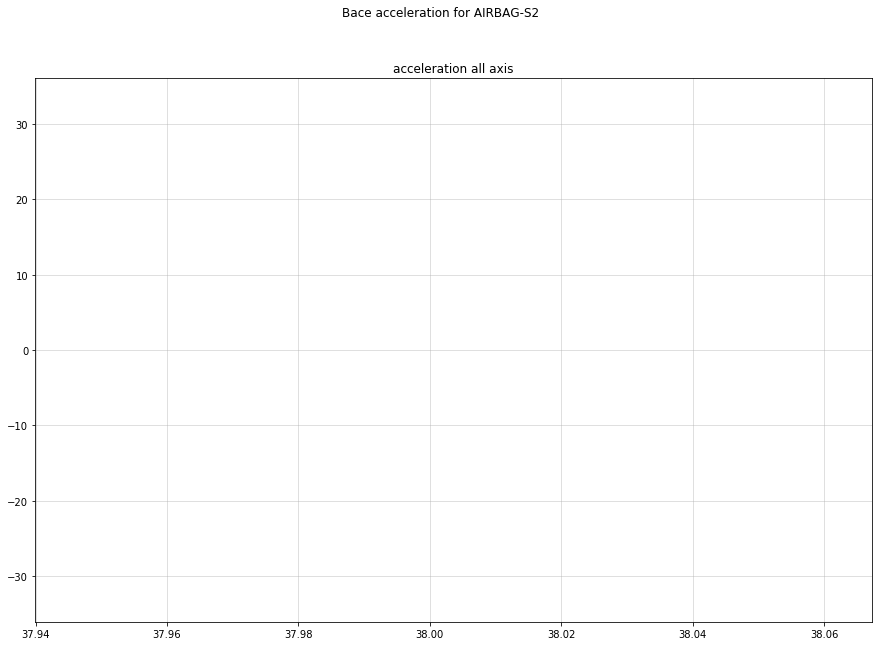

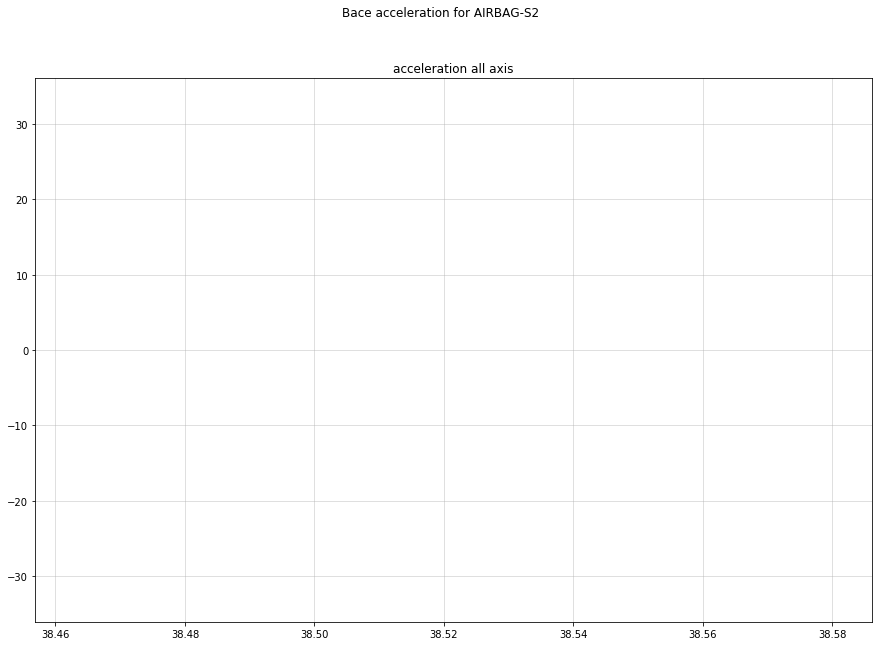

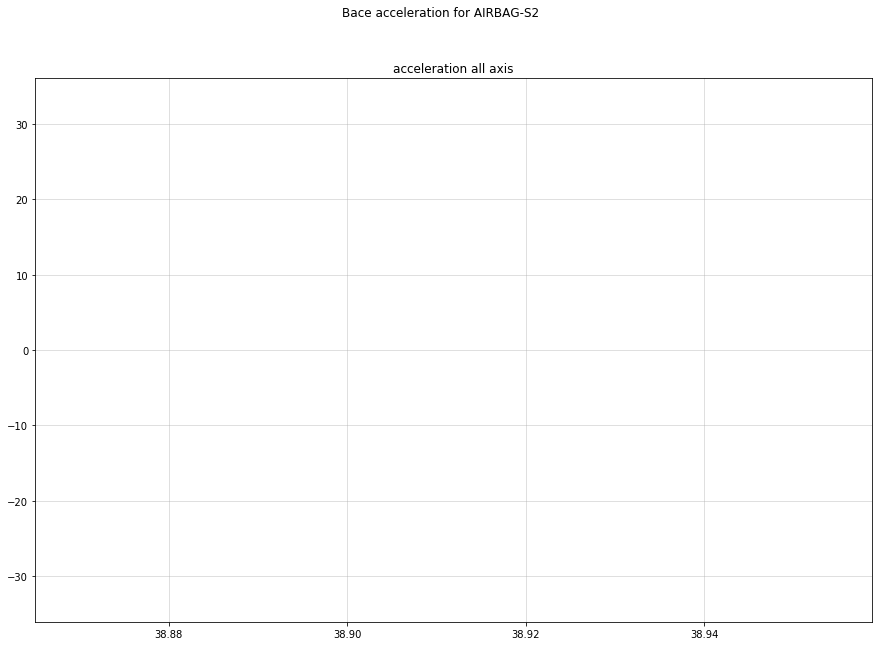

In [77]:
plot_all_impact_graphs(s3_data,s3_combined)

# For C1 

In [39]:
c1_data=read_data('C1-Airbag.CSV')
c1_combined = read_combined_data('C1-combined.xlsx',c1_data)
add_new_fall_value(c1_data,c1_combined)

    cal_impact_value  impact_value   difference_in_min
0           6.392633      6.395200           -0.002567
1           7.010133      7.011017           -0.000883
2           8.086633      8.090867           -0.004233
3           8.911200      8.913433           -0.002233
4           9.506800      9.509600           -0.002800
5           9.969900      9.973450           -0.003550
6          12.784967     12.790817           -0.005850
7          13.373267     13.376250           -0.002983
8          14.272467     14.276000           -0.003533
9          14.843533     14.849433           -0.005900
10         15.365700     15.370333           -0.004633
11         15.833867     15.837033           -0.003167
12         16.772233     16.775300           -0.003067
13         17.434000     17.433867            0.000133
14         18.558567     18.561017           -0.002450
15         19.156867     19.153933            0.002933
16         22.614300     22.614667           -0.000367
17        

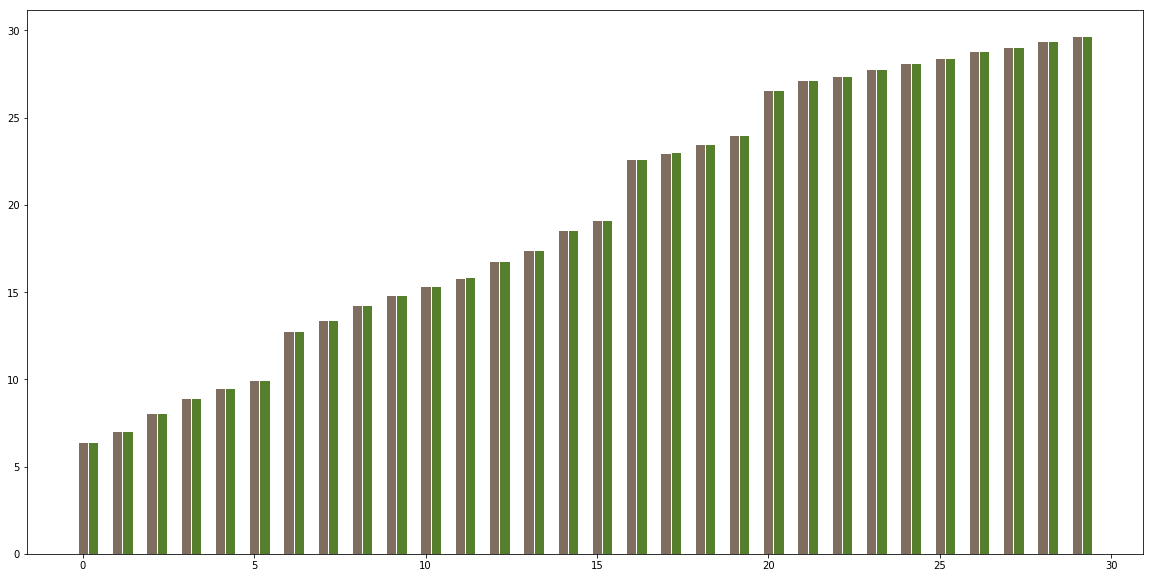

In [58]:
plot_offset(c1_data,c1_combined)

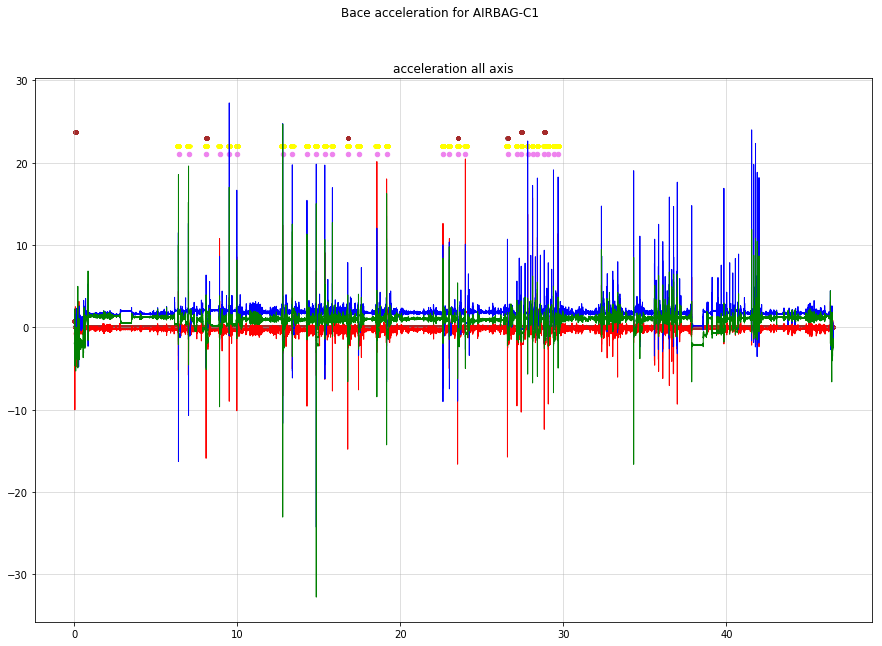

In [42]:
big_size_plot_of_acceleration_vs_time(data=c1_data,label='C1')

# For C2

In [45]:
c2_data=read_data('C2-Airbag.CSV')
c2_combined = read_combined_data('C2-combined.xlsx',c2_data)
add_new_fall_value(c2_data,c2_combined)

    cal_impact_value  impact_value   difference_in_min
0           4.463750      4.475100           -0.011350
1           5.013400      5.022583           -0.009183
2           5.697217      5.706733           -0.009517
3           6.134783      6.141933           -0.007150
4           6.506417      6.515767           -0.009350
5           6.825750      6.831433           -0.005683
6           7.283083      7.290300           -0.007217
7           7.616083      7.623100           -0.007017
8           8.053883      8.061167           -0.007283
9           8.349950      8.355767           -0.005817
10         10.167150     10.166767            0.000383
11         10.457983     10.458617           -0.000633
12         10.795550     10.800417           -0.004867
13         11.092417     11.097950           -0.005533
14         12.166583     12.171950           -0.005367
15         12.468150     12.475317           -0.007167
16         12.763117     12.770400           -0.007283
17        

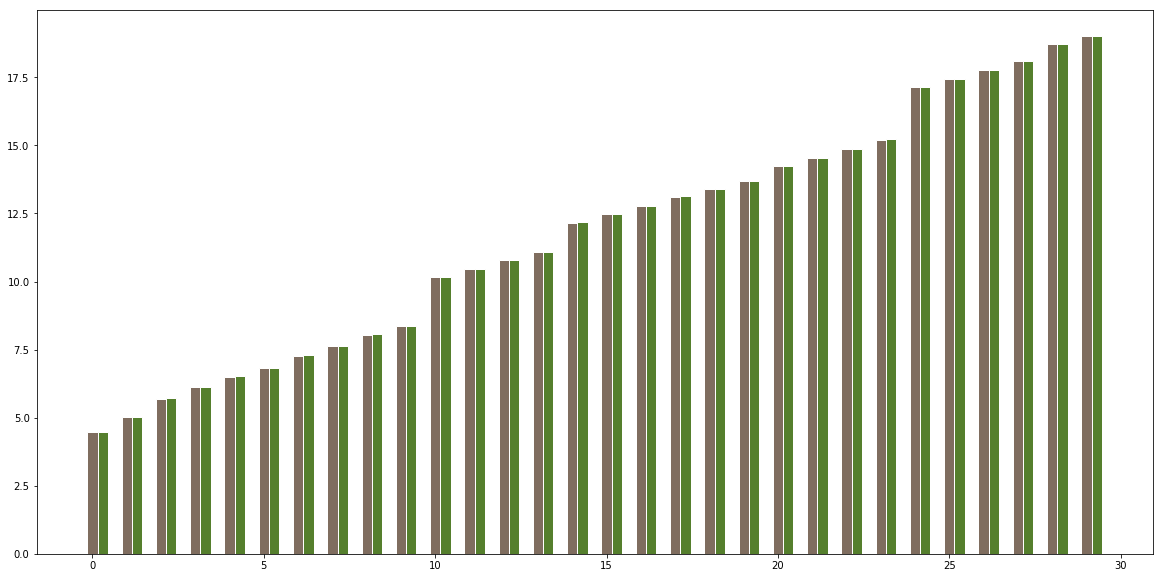

In [59]:
plot_offset(c2_data,c2_combined)

# For C3 

In [47]:
c3_data=read_data('C3-Airbag.CSV')
c3_combined = read_combined_data('C3-combined.xlsx',c3_data)
add_new_fall_value(c3_data,c3_combined)

    cal_impact_value  impact_value   difference_in_min
0           4.549533      4.560700           -0.011167
1           4.983133      4.995633           -0.012500
2           5.234833      5.245683           -0.010850
3           5.738800      5.749450           -0.010650
4           6.098667      6.109200           -0.010533
5           6.361533      6.370500           -0.008967
6           6.903900      6.914417           -0.010517
7           7.179067      7.186533           -0.007467
8           7.503567      7.509583           -0.006017
9           7.799467      7.806000           -0.006533
10          9.631300      9.639633           -0.008333
11          9.969467      9.976450           -0.006983
12         10.648133     10.657133           -0.009000
13         10.995667     11.004783           -0.009117
14         11.602733     11.607850           -0.005117
15         11.917400     11.926733           -0.009333
16         12.322767     12.328317           -0.005550
17        

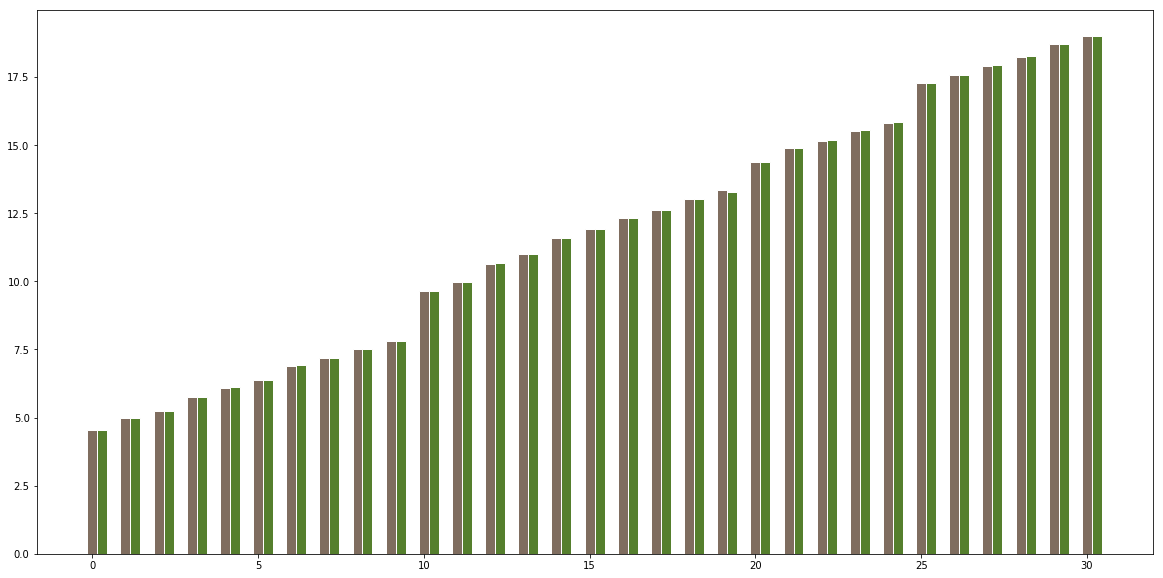

In [60]:
plot_offset(c3_data,c3_combined)

In [1]:
!pip install jupyerthemes

  ERROR: Could not find a version that satisfies the requirement jupyerthemes (from versions: none)
ERROR: No matching distribution found for jupyerthemes
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
!pip install --upgrade pip

  Found existing installation: pip 19.2.3
    Uninstalling pip-19.2.3:
      Successfully uninstalled pip-19.2.3


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\hp\\AppData\\Local\\Temp\\pip-uninstall-oyqkif2p\\pip.exe'
Consider using the `--user` option or check the permissions.

